In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use("seaborn")
from tqdm import tqdm
import time
from typing import List, Set, Dict, Tuple, Optional, Callable, Iterator, Union 
import math
import pyLDAvis
import pyLDAvis.sklearn as LDAsklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import json

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [56]:
class Model:
    def __init__(self, y_train: np.ndarray, y_test: np.ndarray, scoring: Optional[str] = None, prop_tags: Union[str, int] = 'origin'):
        self.models = pd.DataFrame(columns=[
            'name',
            'data_use',
            'model',
            'confusion_matrice',
            'Error',
            'Jaccard Macro',
            'Precision Macro',
            'Recall Macro',
            'F_mesure Macro',
            'auc Macro',
            'Jaccard Micro',
            'Precision Micro',
            'Recall Micro',
            'F_mesure Micro',
            'auc Micro',
            'proportion_de_prédiction',
            'fit_time',
            'pred_time',
            'y_pred',
            'best_params',
            'grid_params',
            'grid_score',
            'params'
        ])
        self.scoring = scoring
        self.prop_tags = prop_tags
        self.models.set_index('name', inplace=True)
        self.y_train = y_train
        self.y_test = y_test
        self.x = {}
    def save_data(self, path: str):
        self.models.drop(['model'], axis=1).loc[self.models['y_pred'].notna()].to_pickle(path=path)
        print('données du fichier '+ path + ' bien sauvegardé')
    def append_data(self, path: str):
        new_data = pd.read_pickle(path)
        self.models = self.models.append(new_data)
        print('données du fichier '+ path + ' bien chargé')
    def add_model(self, name: str, model, params=None):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models.loc[name, 'model'] = model
        self.models.loc[name]['grid_params'] = params
    def add_prediction(self, name: str, y_pred: np.ndarray, fit_time: float = 0, pred_time: float = 0):
        """
        ajout des données prédite (utilisé pour les models non supervisé).
        """
        self.models.loc[name, 'fit_time'] = fit_time
        self.models.loc[name, 'pred_time'] = pred_time
        self.models.loc[name]['y_pred'] = y_pred
    def add_data(self, name: str, x_train, x_test):
        self.x[name] = {
            'x_train': x_train,
            'x_test': x_test
        }
    def fit(self, name: Union[str, list] = 'all', data_name=None, cv: Optional[int] = None):
        if name == 'all':
            name = self.models.index.to_list()
        elif type(name) == str:
            print('préparation du model ' + str(name))
            self._fit_process(self.models.loc[name], data_name, cv)
        elif type(name) == list:
            print('préparation des models ' + ' '.join(name))
            for model_name in name:
                self._fit_process(self.models.loc[model_name], data_name, cv)
    def _fit_process(self, model: pd.Series, data_name: str, cv: Optional[int]):
        if data_name == None:
            data_name = list(self.x.keys())[-1]
        x_train = self.x[data_name]['x_train']
        x_test = self.x[data_name]['x_test']
        if model['grid_params'] != None:
            grid = GridSearchCV(model['model'], model['grid_params'], n_jobs=-1, cv=cv, scoring=self.scoring, verbose=3)
            grid.fit(x_train, self.y_train)
            model['grid_score'] = {
                'mean_test_score': grid.cv_results_['mean_test_score'],
                'mean_fit_time': grid.cv_results_['mean_fit_time'],
                'mean_score_time': grid.cv_results_['mean_score_time'],
                'params': grid.cv_results_['params']
            }
            model['model'] = grid.best_estimator_
        start = time.time()
        model['model'].fit(x_train, self.y_train)
        stop = time.time()
        print('le model '+model.name+' à fini son entrainement')
        model['fit_time'] = stop - start
        model['best_params'] = model['model'].get_params()
        model['data_use'] = data_name
        start = time.time()
        y_pred = np.array(model['model'].predict_proba(x_test))[:,:,1].T
        stop = time.time()
        model['pred_time'] = stop - start
        model['y_pred'] = y_pred
        self.compute_perf(model.name)
        print('tout est bon pour le model '+model.name)
    def compute_perf(self, model_name: str, prop_tags: Optional[Union[str, int]] = None):
        model: pd.Series = self.models.loc[model_name]
        y_true: np.ndarray = self.y_test
        y_pred: np.ndarray = model['y_pred']
        n_classes = y_true.shape[1]
        n_indiv = y_true.shape[0]
        if not prop_tags :
            prop_tags = self.prop_tags
        if prop_tags == 'origin':
            prop_tags = y_true.sum()/n_indiv
        i = 0.5
        seuil = 1
        while i > 0.005 :
            if (y_pred >= seuil).sum()/n_indiv < prop_tags :
                seuil -= i
            else :
                seuil += i
            i /= 2
        y_predict = y_pred >= seuil
        mcm = metrics.multilabel_confusion_matrix(y_true, y_predict)
        tn = mcm[:, 0, 0].mean()
        tp = mcm[:, 1, 1].mean()
        fn = mcm[:, 1, 0].mean()
        fp = mcm[:, 0, 1].mean()
        model['confusion_matrice'] = [[tn, fn], [fp, tp]]
        model['Error'] = metrics.hamming_loss(y_test, y_predict)
        model['Jaccard Macro'] = metrics.jaccard_score(y_test, y_predict, average='macro')
        model['Precision Macro'] = metrics.precision_score(y_test, y_predict, average='macro')
        model['Recall Macro'] = metrics.recall_score(y_test, y_predict, average='macro')
        model['F_mesure Macro'] = metrics.f1_score(y_test, y_predict, average='macro')
        model['Jaccard Micro'] = metrics.jaccard_score(y_test, y_predict, average='micro')
        model['Precision Micro'] = metrics.precision_score(y_test, y_predict, average='micro')
        model['Recall Micro'] = metrics.recall_score(y_test, y_predict, average='micro')
        model['F_mesure Micro'] = metrics.f1_score(y_test, y_predict, average='micro')
        model['proportion_de_prédiction'] = (tp + fp)/(tp + fn)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
            if y_true[:, i].sum() == 0:
                tpr[i] = fpr[i]
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision, recall, _ = metrics.precision_recall_curve(y_true.ravel(), y_pred.ravel())
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes
            
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
        
        model['auc Micro'] = roc_auc["micro"]
        model['auc Macro'] = roc_auc["macro"]
        model['params'] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'precision': precision,
            'recall': recall
        }
    def plot_roc(self, model_list: list = [], plot_size: int = 10):
        if model_list == []:
            model_list = self.models.index.to_list()
        lenth = len(model_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, name in enumerate(model_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            model = self.models.loc[name]
            fpr = model['params']['fpr']
            tpr = model['params']['tpr']
            roc_auc = model['params']['roc_auc']
            plt.plot(
                fpr["micro"],
                tpr["micro"],
                label="micro-average Courbe ROC (surface = {0:0.2f})".format(roc_auc["micro"])
            )
            plt.plot(
                fpr["macro"],
                tpr["macro"],
                label="macro-average Courbe ROC (surface = {0:0.2f})".format(roc_auc["macro"])
            )
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel("Ratio Faux Positif", fontsize=14)
            plt.ylabel("Ratio Vrais Positif", fontsize=14)
            plt.title("Courbe ROC du model : "+ name, fontsize=16)
            plt.legend(loc="lower right", fontsize=12)
        plt.show()
    def plot_precision_recall(self, model_list: list = [], plot_size: int = 10):
        if model_list == []:
            model_list = self.models.index.to_list()
        lenth = len(model_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, name in enumerate(model_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            model = self.models.loc[name]
            precision = model['params']['precision']
            recall = model['params']['recall']
            plt.plot(
                precision,
                recall
            )
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel("Précision", fontsize=14)
            plt.ylabel("Recall", fontsize=14)
            plt.title("Courbe Précision Recall du model : "+ name, fontsize=16)
        plt.show()
    def plot_perf(self, perf_list: List[str] = [], plot_size: int = 10, model_list: List = []):
        if perf_list == []:
            perf_list = ['Error', 'Jaccard Macro', 'Precision Macro',
                        'Recall Macro', 'F_mesure Macro', 'auc Macro',
                        'Jaccard Micro', 'Precision Micro', 'Recall Micro',
                        'F_mesure Micro', 'auc Micro', 'proportion_de_prédiction',
                        'fit_time', 'pred_time']
        if model_list == []:
            models = self.models
        else:
            models = self.models.loc[model_list]
        lenth = len(perf_list)
        sqrt = math.floor(math.sqrt(lenth))
        plt.figure(figsize=(plot_size*sqrt,plot_size*math.ceil(lenth/sqrt)))
        for it, score in enumerate(perf_list):
            plt.subplot(math.ceil(lenth/sqrt), sqrt, it+1)
            value = self.models[score].values.astype('float')
            colors = cm.plasma_r(value / float(max(value)))
            plt.bar(self.models.index, value, color = colors)
            plt.title('Score '+score+' par Modele', fontsize=16)
            plt.xticks(rotation=30, fontsize=14)
            plt.yticks(fontsize=16)
            plt.xlabel('')
            plt.ylabel(score, fontsize=14)
        plt.show()
    def plot_grid(self, model_name: str, plot_height: int = 10, model_lenth: float = 1.5):
        model = self.models.loc[model_name]
        params = []
        val = ''
        for param_list in model['grid_score']['params']:
            for param in param_list.keys():
                val+= str(param) + ': ' +str(param_list[param]) + '\n'
            params.append(val)
            val = ''
        plt.figure(figsize=(model_lenth*len(params), plot_height*3))
        plt.subplot(311)
        value = model['grid_score']['mean_test_score']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('Score moyen par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        
        plt.subplot(312)
        value = model['grid_score']['mean_fit_time']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('temp d\'entrainement par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        
        plt.subplot(313)
        value = model['grid_score']['mean_score_time']
        colors = cm.plasma_r(value / float(max(value)))
        plt.bar(params, value, color = colors)
        plt.title('temp de prédiction par paramètre', fontsize=16)
        plt.xticks(rotation=30, fontsize=14)
        plt.yticks(fontsize=16)
        plt.xlabel('')
        plt.ylabel('score moyen des folds', fontsize=14)
        plt.show

In [5]:
def plot_top_words(model, feature_names, n_top_words, nb_line_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_line_plot)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_line_plot*6):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Préparation

In [6]:
post = pd.read_csv('Data/Posts_Clean_sample.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
post = post.sample(n=20000, random_state=7)

In [7]:
X = post["Text"].values
Y = post["Tags_list"].str.split().values
x_train, x_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=9000)

In [8]:
tags_binarizer = MultiLabelBinarizer()
tags_binarizer.fit(y_train)
y_train: np.ndarray = np.array(tags_binarizer.transform(y_train))
y_test: np.ndarray = np.array(tags_binarizer.transform(y_test))

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=2000)
count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tf_idf = TfidfTransformer()
tf_idf.fit(x_train_counts)
x_train_tfidf = tf_idf.transform(x_train_counts)
x_test_tfidf = tf_idf.transform(x_test_counts)

In [64]:
models = Model(y_train=y_train, y_test=y_test, scoring='f1_micro')
models.add_data('tf-idf', x_train_tfidf, x_test_tfidf)
models.append_data('Models/models.pkl')

données du fichier Models/models.pkl bien chargé


## selection nb de mots

In [17]:
models_mots = Model(y_train=y_train, y_test=y_test)
# models_mots.append_data('Models/models_mots.pkl')

In [20]:
count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=50000)
count_vect_trait.fit(x_train)
x_train_counts_50000 = count_vect_trait.transform(x_train)
x_test_counts_50000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_50000)
x_train_tfidf_50000 = tf_idn_trait.transform(x_train_counts_50000)
x_test_tfidf_50000 = tf_idn_trait.transform(x_test_counts_50000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=30000)
count_vect_trait.fit(x_train)
x_train_counts_30000 = count_vect_trait.transform(x_train)
x_test_counts_30000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_30000)
x_train_tfidf_30000 = tf_idn_trait.transform(x_train_counts_30000)
x_test_tfidf_30000 = tf_idn_trait.transform(x_test_counts_30000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=20000)
count_vect_trait.fit(x_train)
x_train_counts_20000 = count_vect_trait.transform(x_train)
x_test_counts_20000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_20000)
x_train_tfidf_20000 = tf_idn_trait.transform(x_train_counts_20000)
x_test_tfidf_20000 = tf_idn_trait.transform(x_test_counts_20000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=10000)
count_vect_trait.fit(x_train)
x_train_counts_10000 = count_vect_trait.transform(x_train)
x_test_counts_10000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_10000)
x_train_tfidf_10000 = tf_idn_trait.transform(x_train_counts_10000)
x_test_tfidf_10000 = tf_idn_trait.transform(x_test_counts_10000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=5000)
count_vect_trait.fit(x_train)
x_train_counts_5000 = count_vect_trait.transform(x_train)
x_test_counts_5000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_5000)
x_train_tfidf_5000 = tf_idn_trait.transform(x_train_counts_5000)
x_test_tfidf_5000 = tf_idn_trait.transform(x_test_counts_5000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=3000)
count_vect_trait.fit(x_train)
x_train_counts_3000 = count_vect_trait.transform(x_train)
x_test_counts_3000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_3000)
x_train_tfidf_3000 = tf_idn_trait.transform(x_train_counts_3000)
x_test_tfidf_3000 = tf_idn_trait.transform(x_test_counts_3000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=2000)
count_vect_trait.fit(x_train)
x_train_counts_2000 = count_vect_trait.transform(x_train)
x_test_counts_2000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_2000)
x_train_tfidf_2000 = tf_idn_trait.transform(x_train_counts_2000)
x_test_tfidf_2000 = tf_idn_trait.transform(x_test_counts_2000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=1000)
count_vect_trait.fit(x_train)
x_train_counts_1000 = count_vect_trait.transform(x_train)
x_test_counts_1000 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_1000)
x_train_tfidf_1000 = tf_idn_trait.transform(x_train_counts_1000)
x_test_tfidf_1000 = tf_idn_trait.transform(x_test_counts_1000)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=500)
count_vect_trait.fit(x_train)
x_train_counts_500 = count_vect_trait.transform(x_train)
x_test_counts_500 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_500)
x_train_tfidf_500 = tf_idn_trait.transform(x_train_counts_500)
x_test_tfidf_500 = tf_idn_trait.transform(x_test_counts_500)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=300)
count_vect_trait.fit(x_train)
x_train_counts_300 = count_vect_trait.transform(x_train)
x_test_counts_300 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_300)
x_train_tfidf_300 = tf_idn_trait.transform(x_train_counts_300)
x_test_tfidf_300 = tf_idn_trait.transform(x_test_counts_300)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=200)
count_vect_trait.fit(x_train)
x_train_counts_200 = count_vect_trait.transform(x_train)
x_test_counts_200 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_200)
x_train_tfidf_200 = tf_idn_trait.transform(x_train_counts_200)
x_test_tfidf_200 = tf_idn_trait.transform(x_test_counts_200)

count_vect_trait = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=100)
count_vect_trait.fit(x_train)
x_train_counts_100 = count_vect_trait.transform(x_train)
x_test_counts_100 = count_vect_trait.transform(x_test)

tf_idn_trait = TfidfTransformer()
tf_idn_trait.fit(x_train_counts_100)
x_train_tfidf_100 = tf_idn_trait.transform(x_train_counts_100)
x_test_tfidf_100 = tf_idn_trait.transform(x_test_counts_100)

forest_50000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 50000', forest_50000)
forest_30000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 30000', forest_30000)
forest_20000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 20000', forest_20000)
forest_10000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 10000', forest_10000)
forest_5000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 5000', forest_5000)
forest_3000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 3000', forest_3000)
forest_2000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 2000', forest_2000)
forest_1000 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 1000', forest_1000)
forest_500 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 500', forest_500)
forest_300 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 300', forest_300)
forest_200 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 200', forest_200)
forest_100 = RandomForestClassifier(n_jobs=-1)
models_mots.add_model('forest 100', forest_100)

# models_mots.add_data('tf-idf 50000', x_train_tfidf_50000, x_test_tfidf_50000)
# models_mots.add_data('tf-idf 30000', x_train_tfidf_30000, x_test_tfidf_30000)
# models_mots.add_data('tf-idf 20000', x_train_tfidf_20000, x_test_tfidf_20000)
# models_mots.add_data('tf-idf 10000', x_train_tfidf_10000, x_test_tfidf_10000)
# models_mots.add_data('tf-idf 5000', x_train_tfidf_5000, x_test_tfidf_5000)
# models_mots.add_data('tf-idf 3000', x_train_tfidf_3000, x_test_tfidf_3000)
# models_mots.add_data('tf-idf 2000', x_train_tfidf_2000, x_test_tfidf_2000)
models_mots.add_data('tf-idf 1000', x_train_tfidf_1000, x_test_tfidf_1000)
models_mots.add_data('tf-idf 500', x_train_tfidf_500, x_test_tfidf_500)
models_mots.add_data('tf-idf 300', x_train_tfidf_300, x_test_tfidf_300)
models_mots.add_data('tf-idf 200', x_train_tfidf_200, x_test_tfidf_200)
models_mots.add_data('tf-idf 100', x_train_tfidf_100, x_test_tfidf_100)

In [21]:
models_mots.fit('forest 50000', 'tf-idf 50000')
models_mots.fit('forest 30000', 'tf-idf 30000')
models_mots.fit('forest 20000', 'tf-idf 20000')
models_mots.fit('forest 10000', 'tf-idf 10000')
models_mots.fit('forest 5000', 'tf-idf 5000')
models_mots.fit('forest 3000', 'tf-idf 3000')
models_mots.fit('forest 2000', 'tf-idf 2000')
models_mots.fit('forest 1000', 'tf-idf 1000')
models_mots.fit('forest 500', 'tf-idf 500')
models_mots.fit('forest 300', 'tf-idf 300')
models_mots.fit('forest 200', 'tf-idf 200')
models_mots.fit('forest 100', 'tf-idf 100')

le model forest 1000 à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest 1000
le model forest 500 à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest 500
le model forest 300 à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest 300
le model forest 200 à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest 200
le model forest 100 à fini son entrainement
tout est bon pour le model forest 100


In [22]:
models_mots.save_data('Models/models_mots.pkl')

données du fichier Models/models_mots.pkl bien sauvegardé


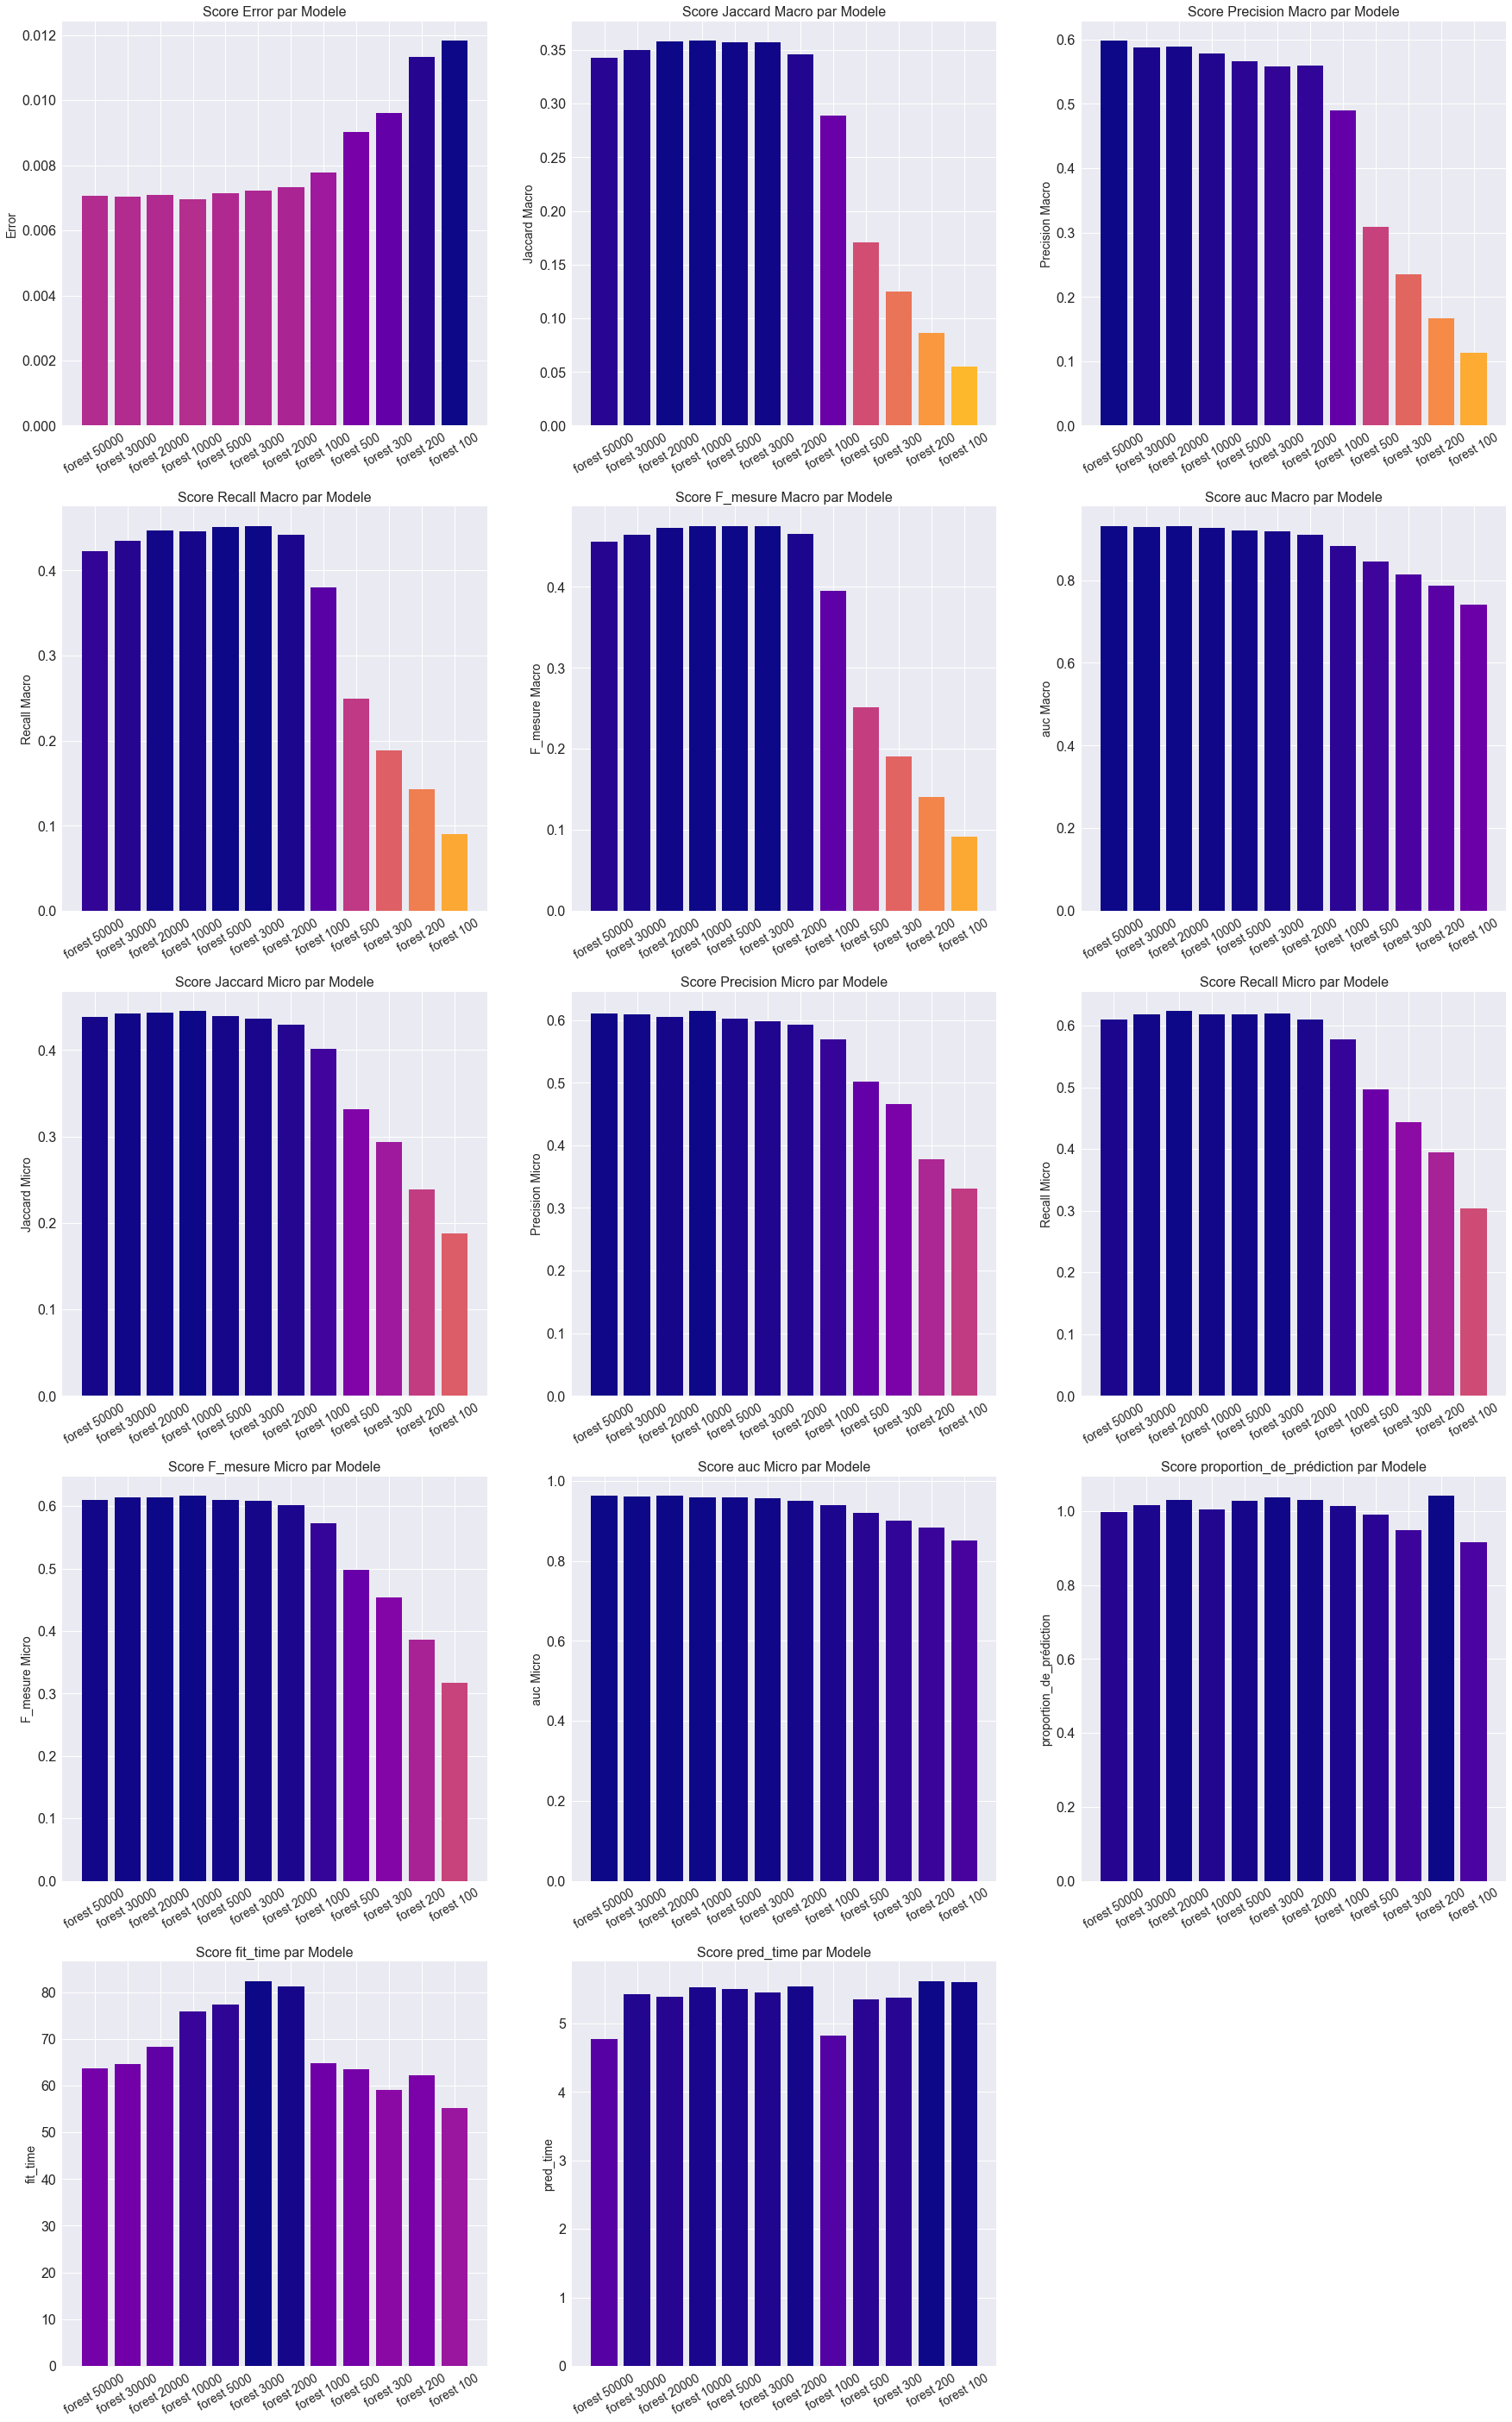

In [23]:
models_mots.plot_perf()

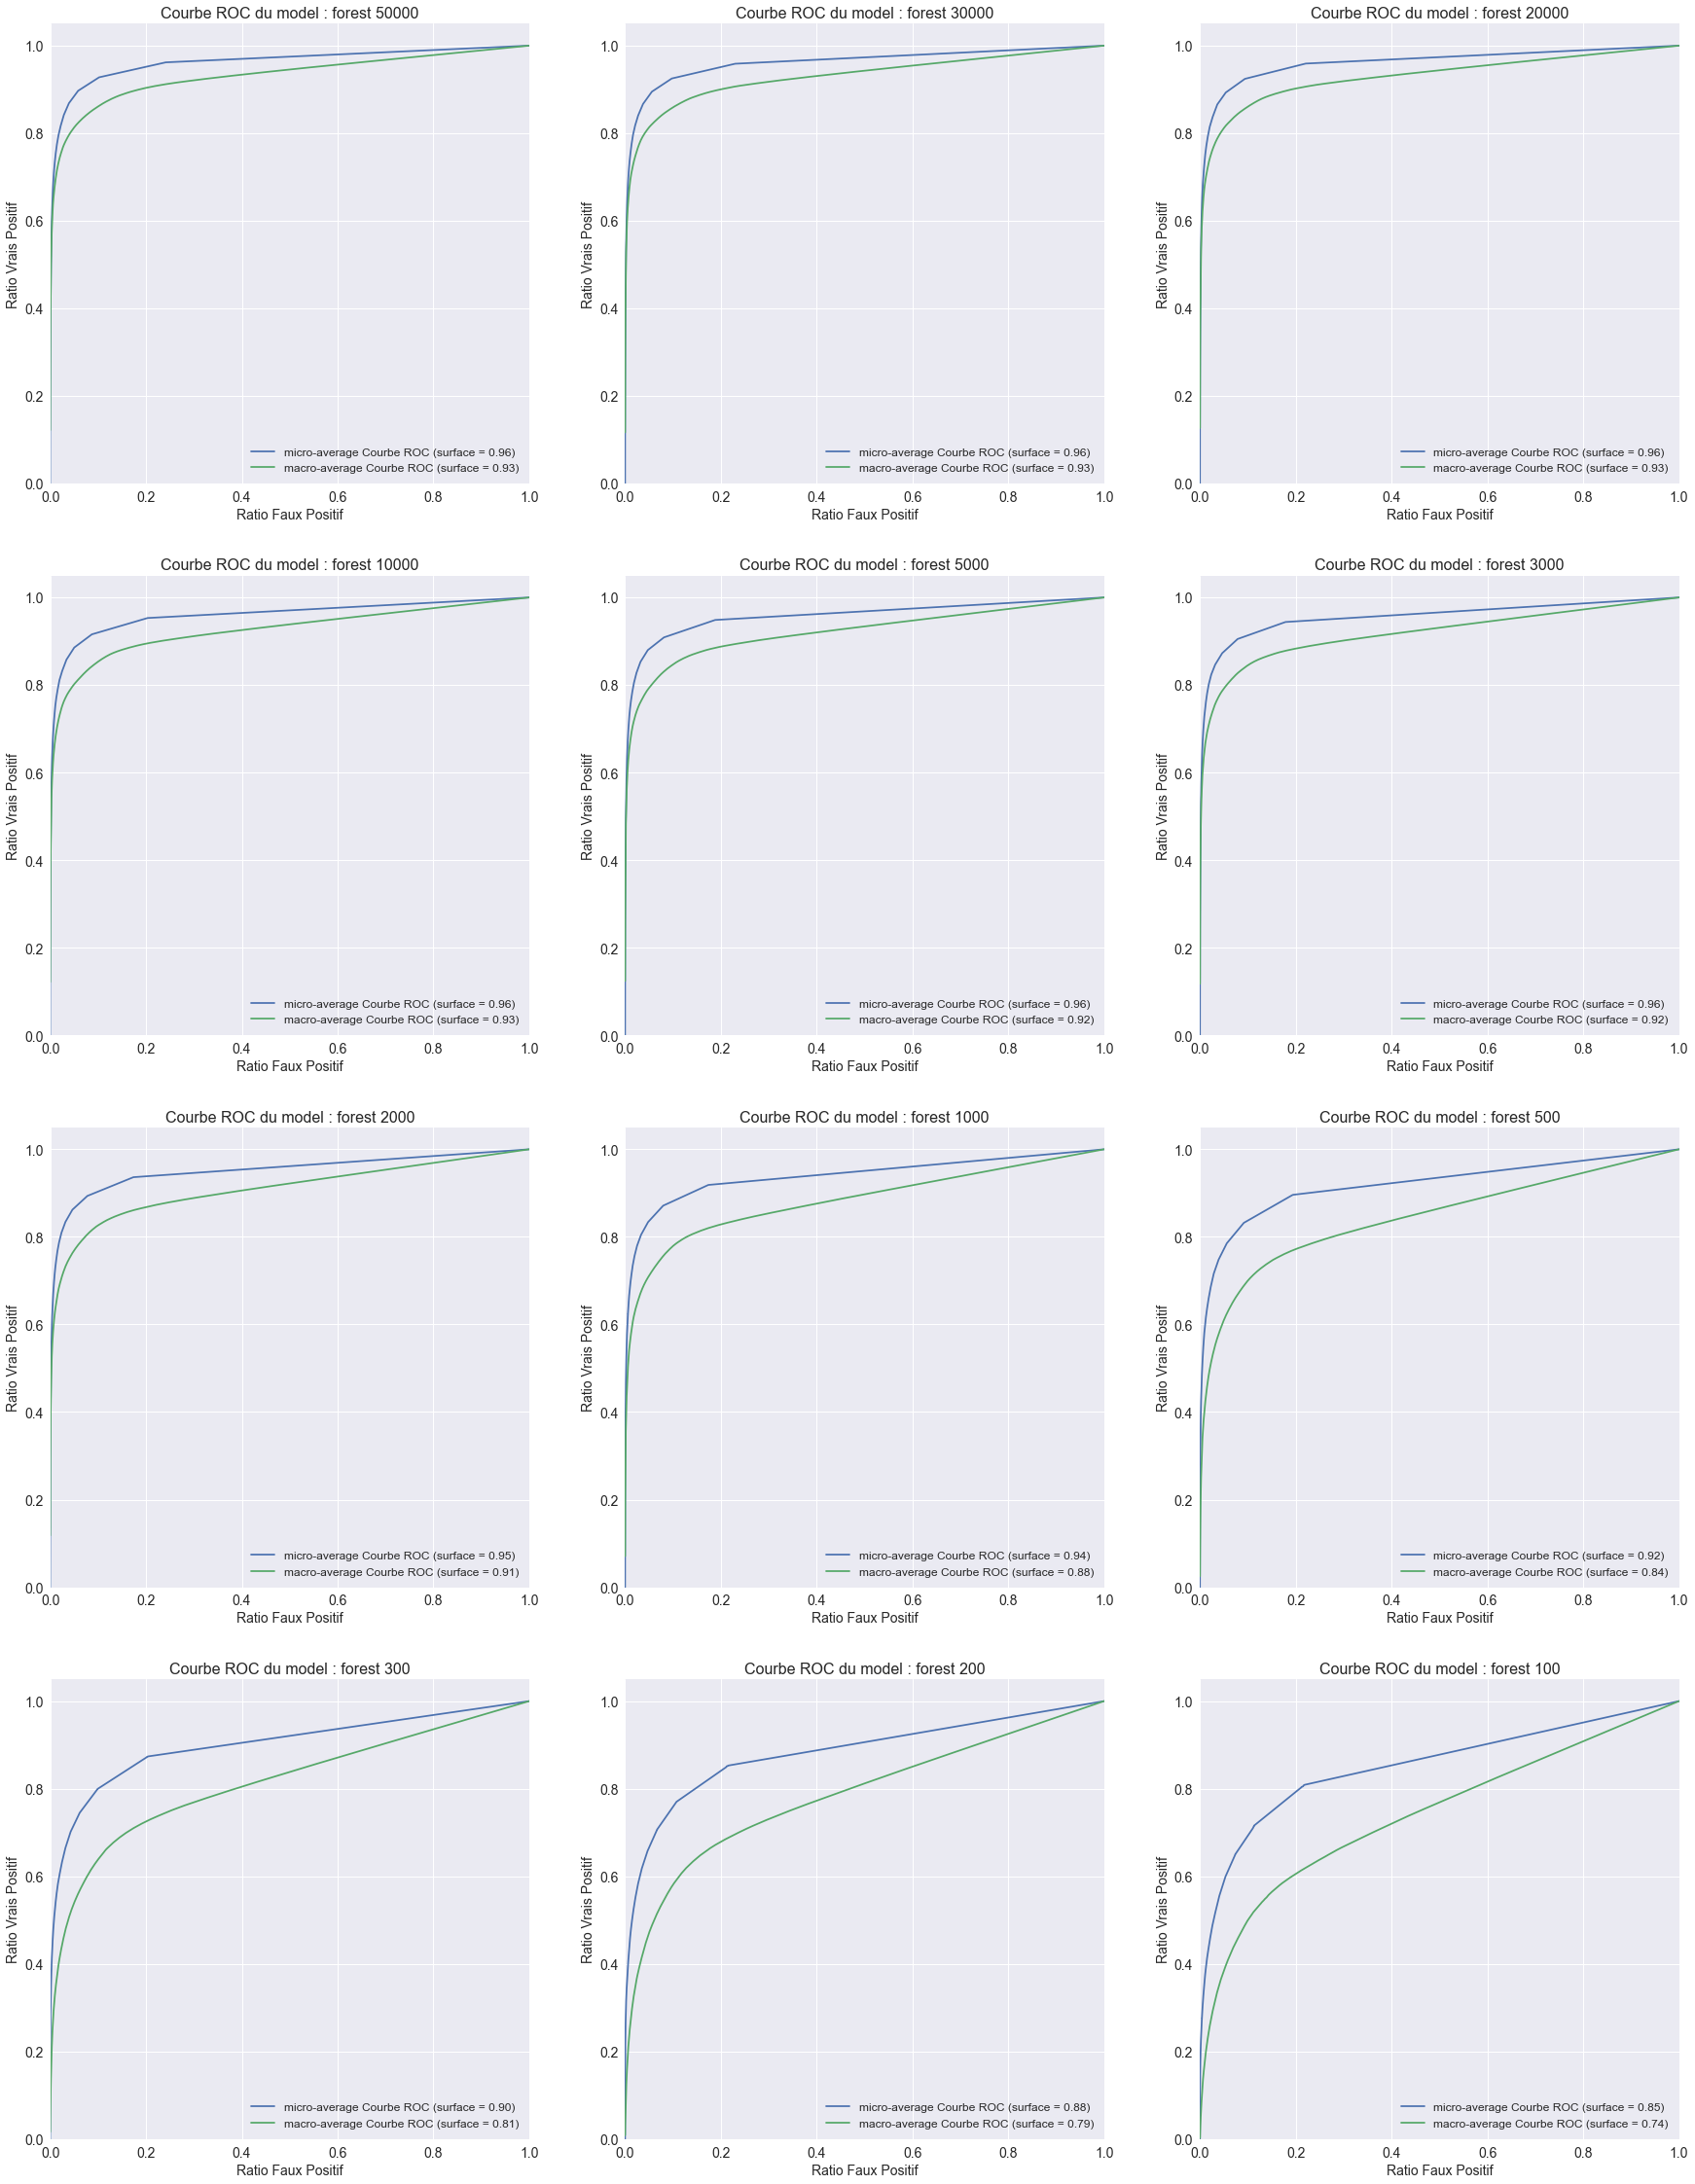

In [24]:
models_mots.plot_roc()

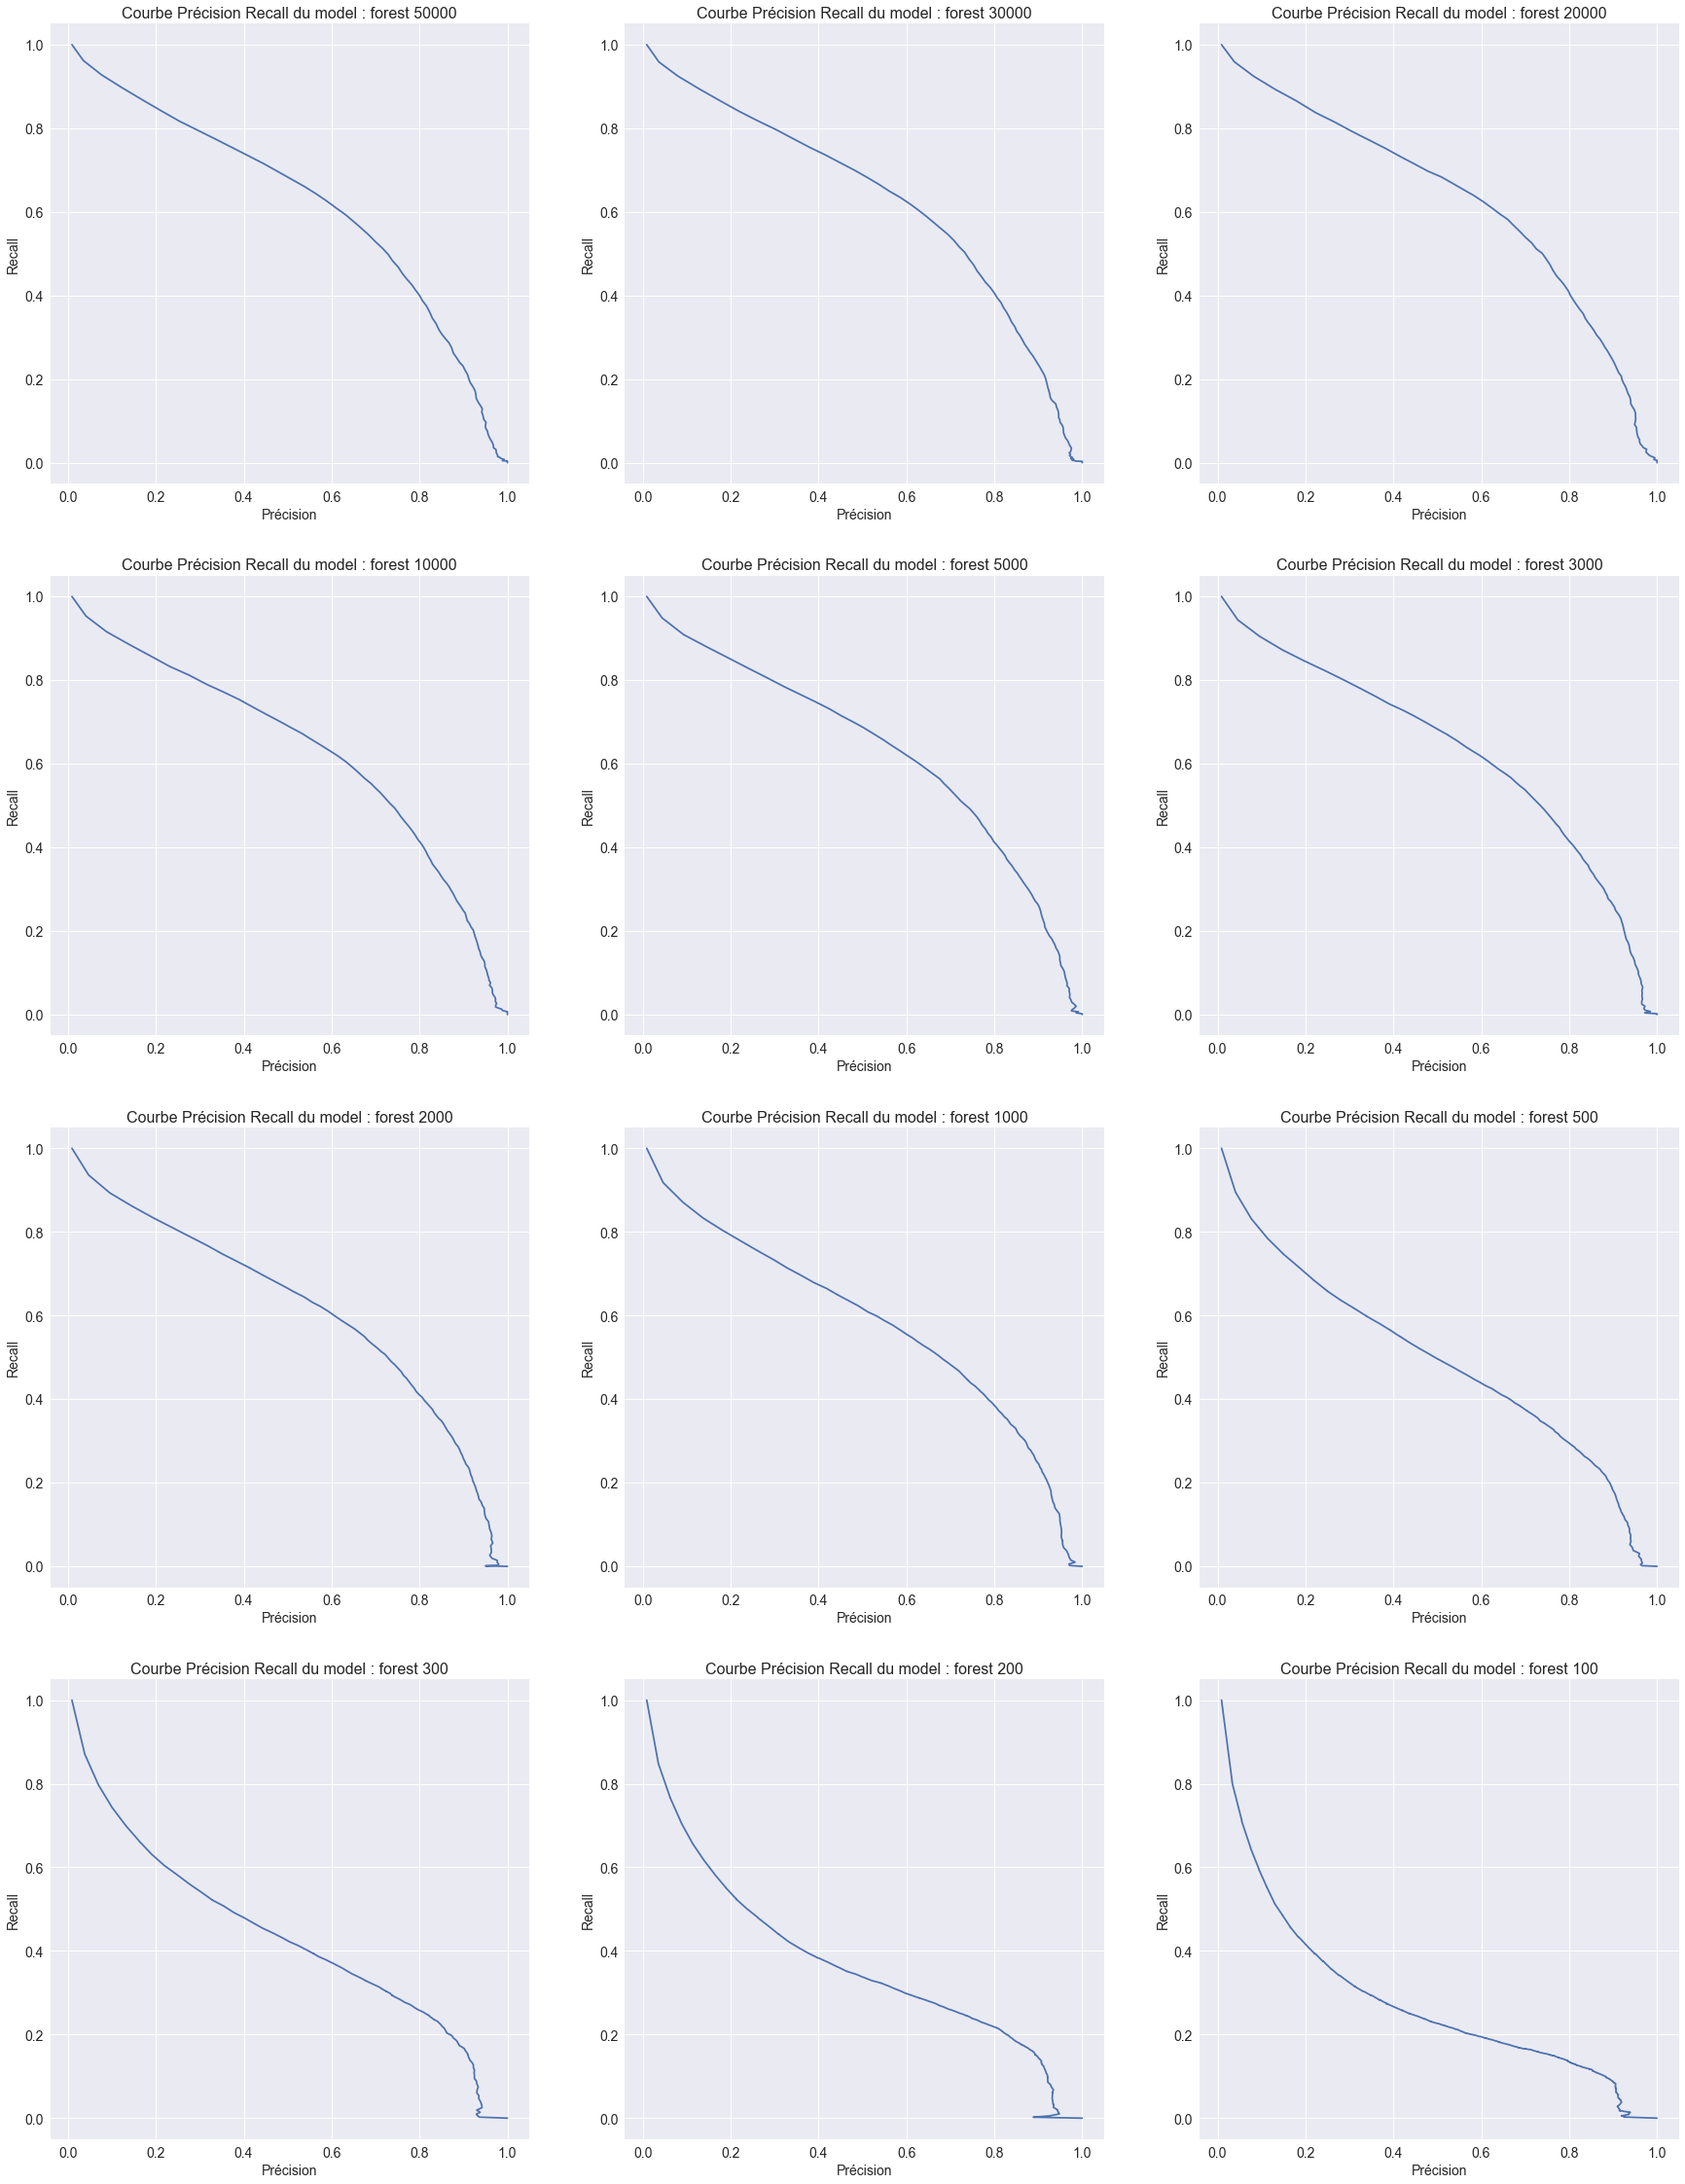

In [25]:
models_mots.plot_precision_recall()

## Supervisée

### selection type de données

In [10]:
models_data = Model(y_train=y_train, y_test=y_test)
models_data.add_data('count', x_train_counts, x_test_counts)
models_data.add_data('tf-idf', x_train_tfidf, x_test_tfidf)

tSVD = TruncatedSVD(n_components=300)
tSVD.fit(x_train_tfidf)
x_train_Tsvd = tSVD.transform(x_train_tfidf)
x_test_Tsvd = tSVD.transform(x_test_tfidf)

lda = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1)
lda.fit(x_train_counts)
x_train_lda = lda.transform(x_train_counts)
x_test_lda = lda.transform(x_test_counts)
models_data.add_data('lda', x_train_lda, x_test_lda)

x_train_Tsvd_lda = np.concatenate((x_train_Tsvd, x_train_lda), axis=1)
x_test_Tsvd_lda = np.concatenate((x_test_Tsvd, x_test_lda), axis=1)
models_data.add_data('Tsvd lda', x_train_Tsvd_lda, x_test_Tsvd_lda)

In [11]:
forest_count = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest count', forest_count)
forest_tfidf = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest tf-idf', forest_tfidf)
forest_lda_tsvd = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest lda Tsvd', forest_lda_tsvd)
forest_lda = RandomForestClassifier(n_jobs=-1)
models_data.add_model('forest lda', forest_lda)

In [12]:
models_data.fit('forest count', 'count')
models_data.fit('forest tf-idf', 'tf-idf')
models_data.fit('forest lda Tsvd', 'Tsvd lda')
models_data.fit('forest lda', 'lda')

le model forest count à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest count
le model forest tf-idf à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest tf-idf
le model forest lda Tsvd à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest lda Tsvd
le model forest lda à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model forest lda


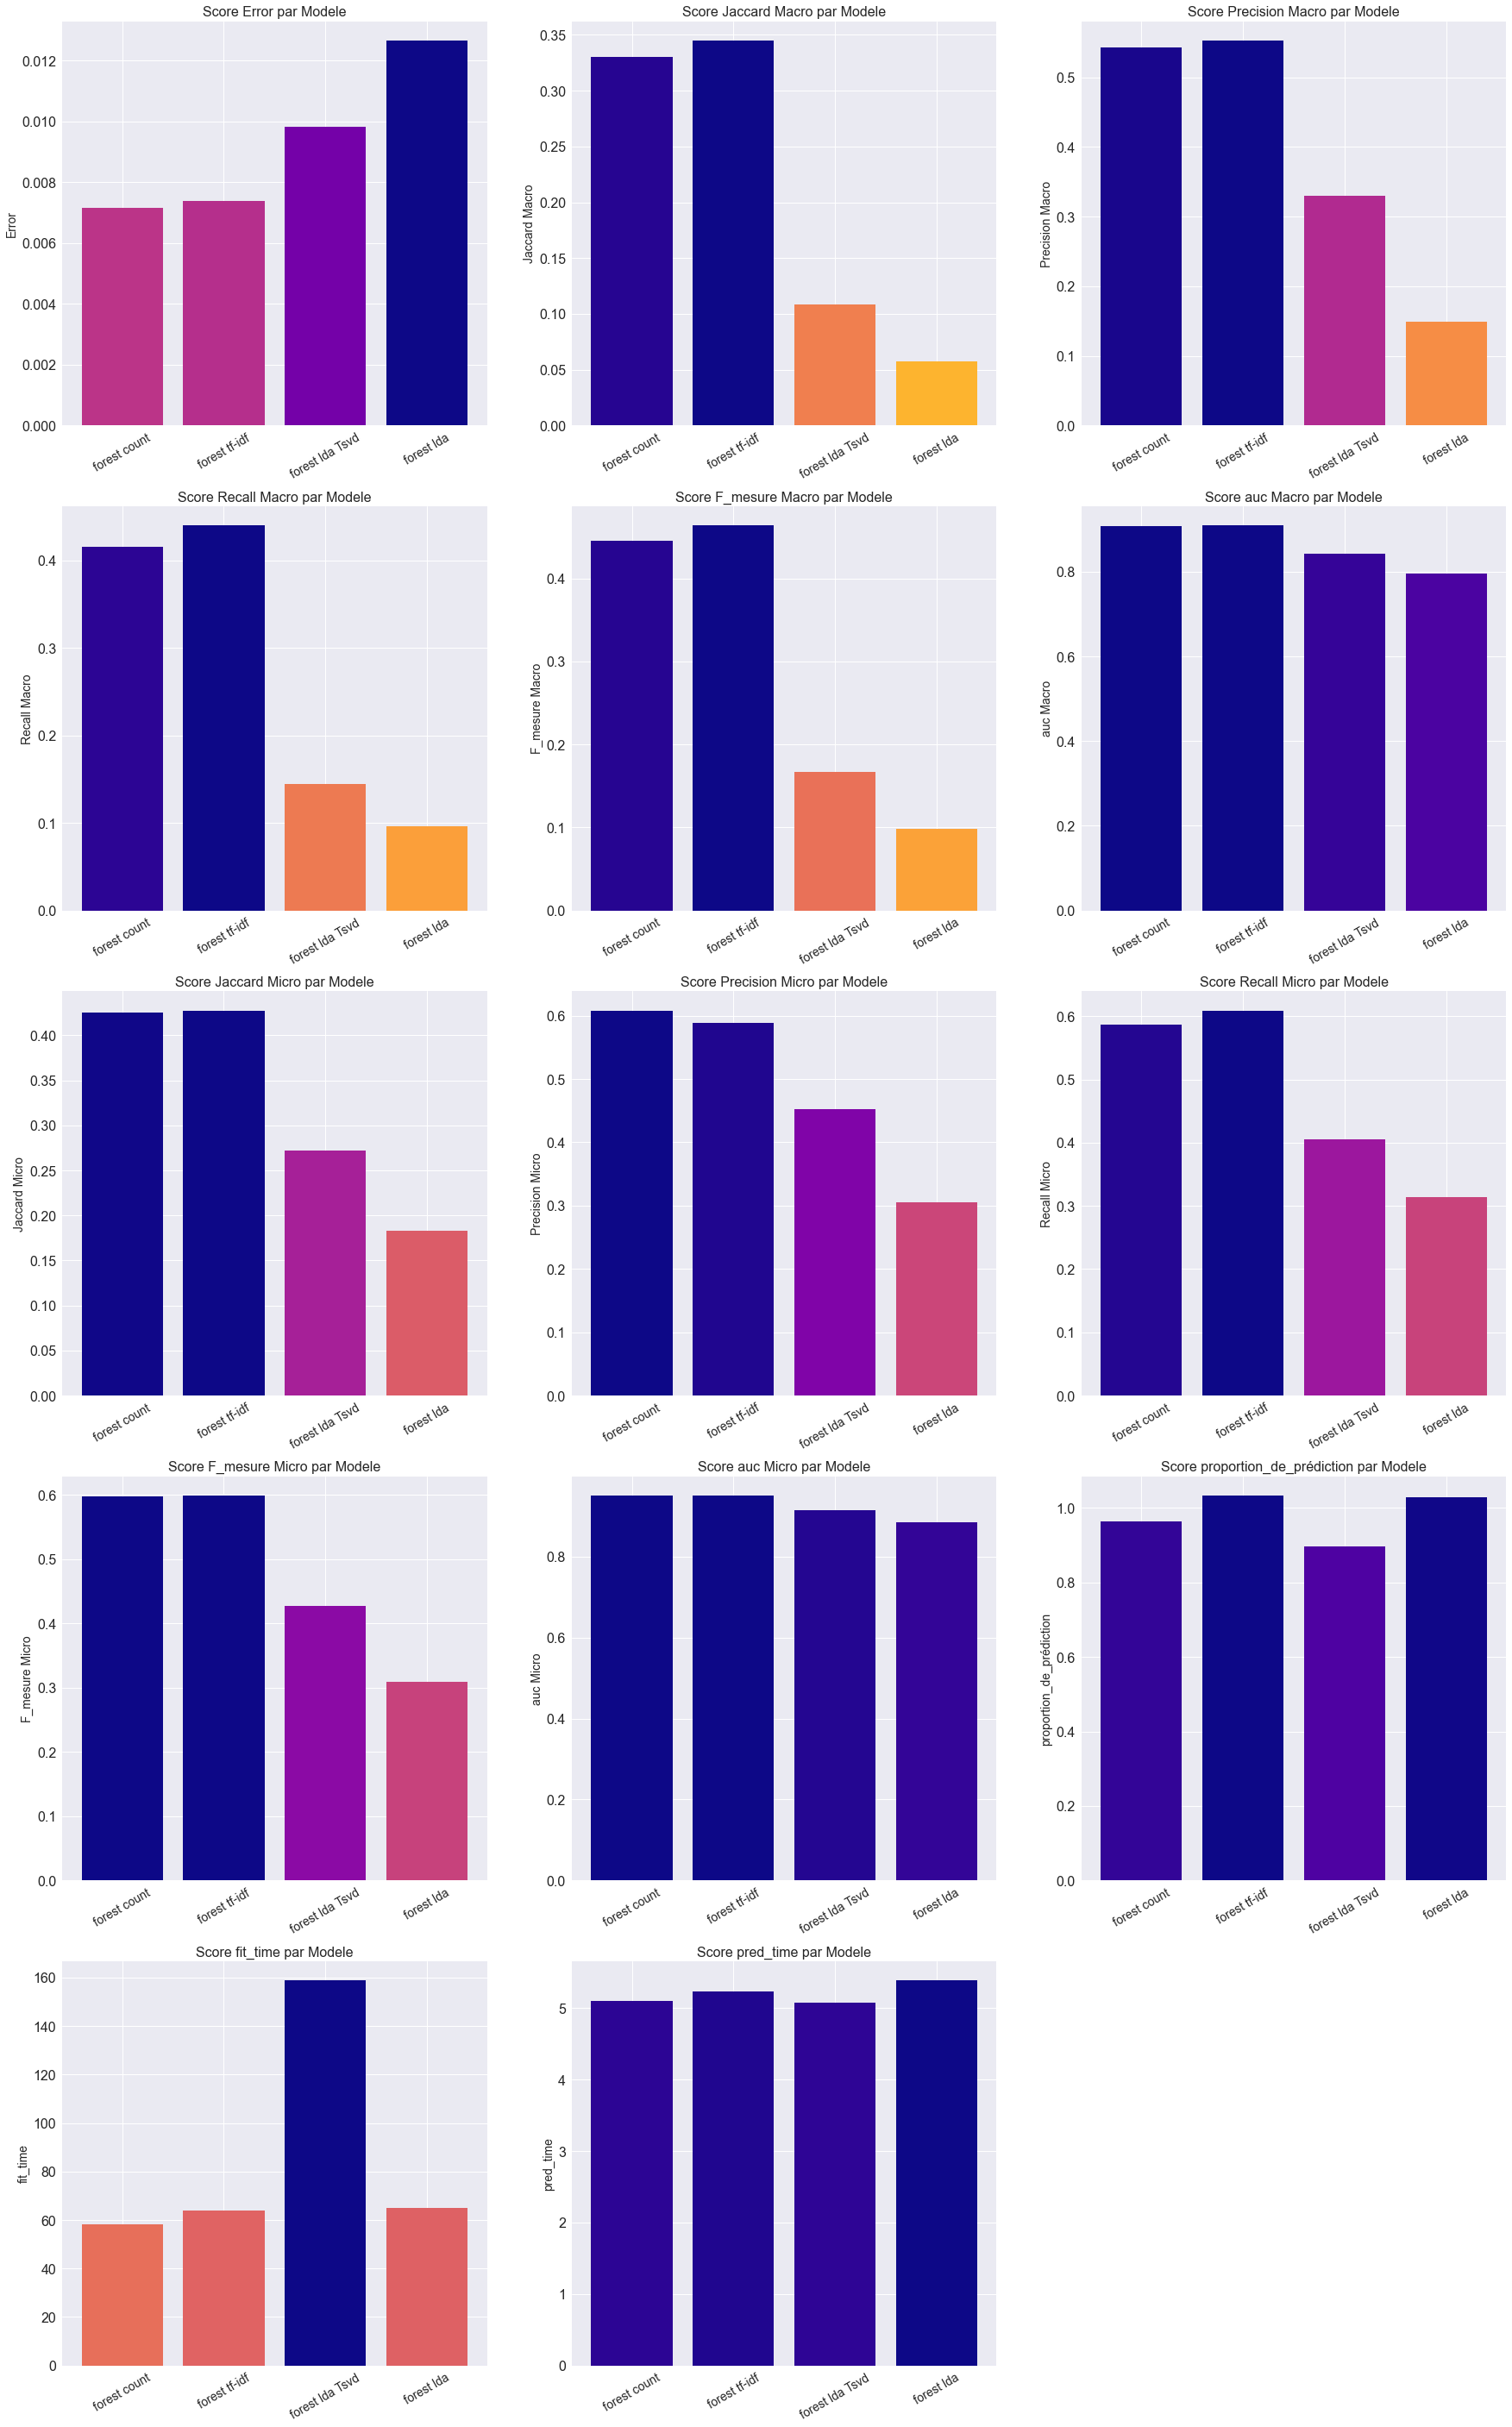

In [13]:
models_data.plot_perf()

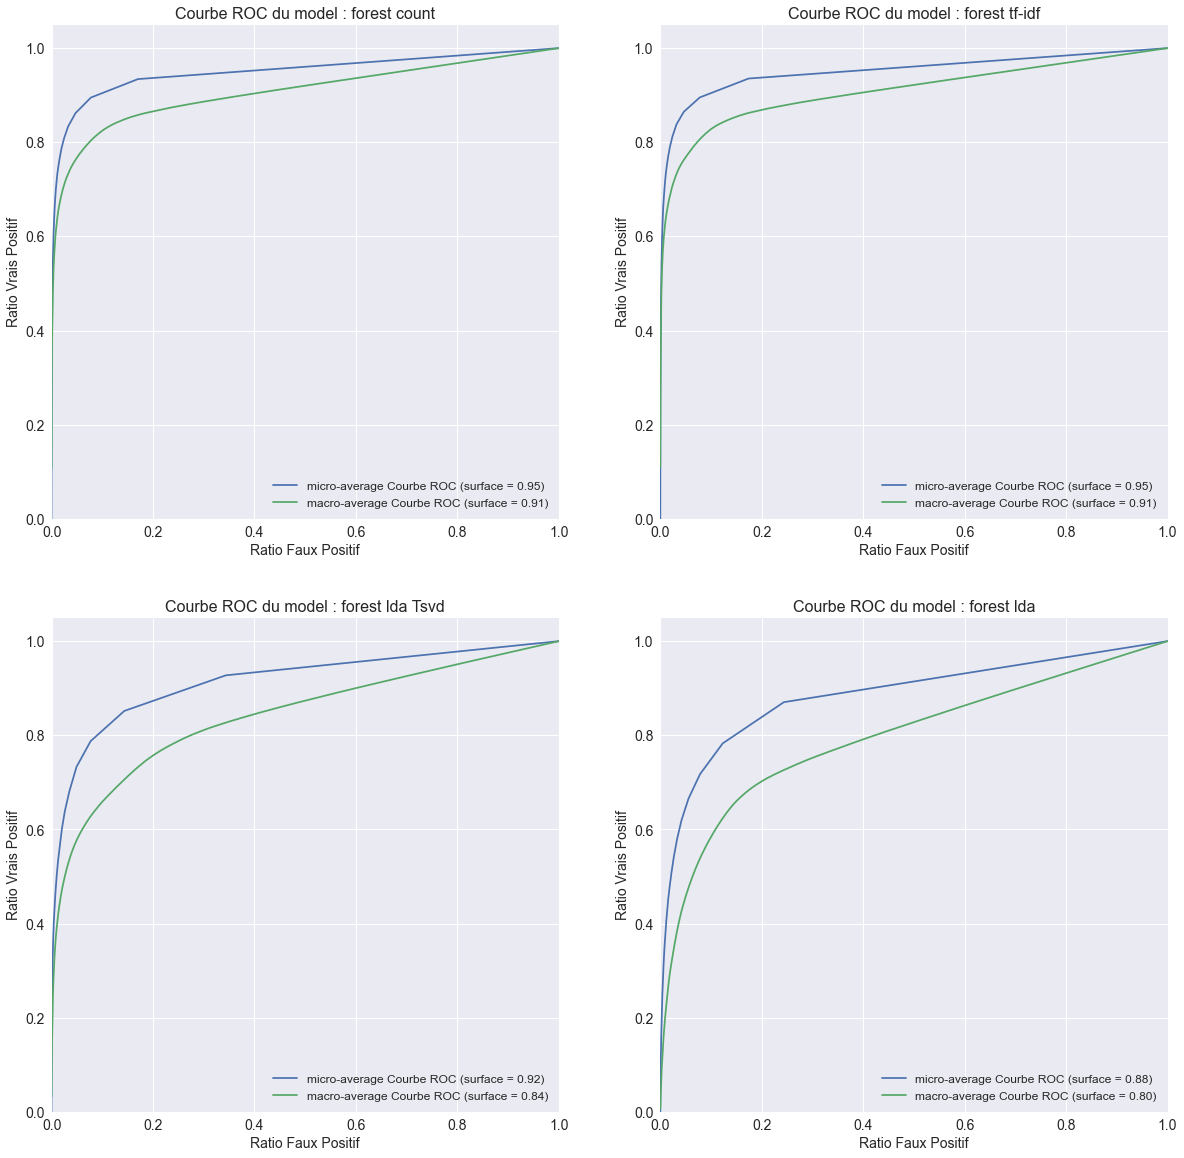

In [14]:
models_data.plot_roc()

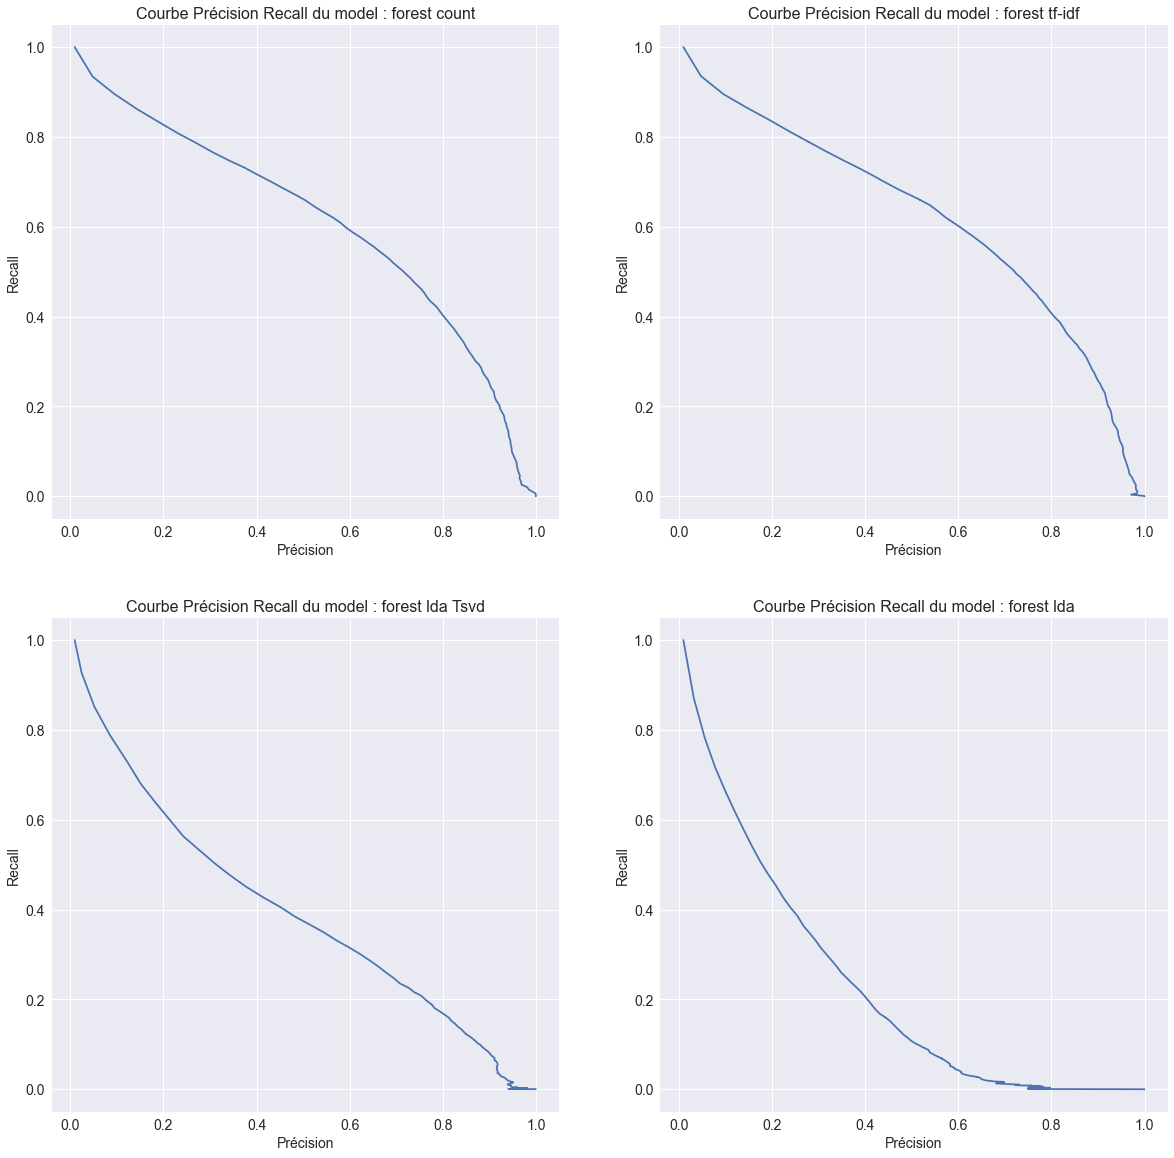

In [15]:
models_data.plot_precision_recall()

In [ ]:
models_data.save_data('Models/models_data.pkl')

### Préparation différents models

In [10]:
knn = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
models.add_model('kNN', knn, knn_params)

decision_tree = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 12, 15, 18, 23, 30, 40, None]}
models.add_model('Decision tree', decision_tree, decision_tree_params)

random_forest = RandomForestClassifier(n_jobs=-1)
random_forest_params = {'n_estimators': np.round(np.logspace(1.2,2.8,8)).astype(int),
                        'bootstrap': [True, False],
                        'max_features': ['sqrt', 'auto', 'log2']}
models.add_model('Random forest', random_forest, random_forest_params)

bagging = BaggingClassifier(n_jobs=-1)
bagging_ovr = OneVsRestClassifier(bagging, n_jobs=-1)
bagging_params = {'estimator__n_estimators': [5, 7, 10, 13, 18]}
models.add_model('Bagging', bagging_ovr, bagging_params)

gradient = GradientBoostingClassifier()
gradient_ovr = OneVsRestClassifier(gradient, n_jobs=-1)
gradient_params = {'estimator__learning_rate': np.logspace(-2.5, 0, 8),
                   'estimator__n_estimators': np.round(np.logspace(1.3,2.5,5)).astype(int)}
models.add_model('Gradient Boosting', gradient_ovr, gradient_params)

naive_bayes = MultinomialNB()
naive_bayes_ovr = OneVsRestClassifier(naive_bayes, n_jobs=-1)
naive_bayes_params = {'estimator__alpha': np.logspace(-4, 1, 40)}
models.add_model('Naive Bayes', naive_bayes_ovr, naive_bayes_params)

linear_svm = LinearSVC()
linear_svm_ovr = OneVsRestClassifier(linear_svm, n_jobs=-1)
linear_svm_params = {'estimator__penalty': ['l1', 'l2'],
                     'estimator__C': [0.1, 1, 10, 100, 1000]}
models.add_model('Linear SVM', linear_svm_ovr, linear_svm_params)

svm = SVC()
svm_ovr = OneVsRestClassifier(svm, n_jobs=-1)
svm_params = {'estimator__kernel': ['rbf', 'poly'],
              'estimator__C': [0.1, 1, 10, 100, 1000],
              'estimator__gamma': [0.1, 1, 10, 100, 'scale', 'auto'],
              'estimator__degree': [2, 3, 4, 5, 6]}
models.add_model('SVM', svm_ovr, svm_params)

random_forest_simple = RandomForestClassifier(n_jobs=-1)
random_forest_chain = ClassifierChain(random_forest_simple)
random_forest_chain_params = {'n_estimators': np.round(np.logspace(1.2,2.8,8)).astype(int),
                               'bootstrap': [True, False],
                               'max_features': ['sqrt', 'auto', 'log2']}
models.add_model('Random Forest Chain', random_forest_chain, random_forest_chain_params)

In [24]:
models.fit('kNN', data_name='tf-idf', cv=5)
models.fit('Decision tree', data_name='tf-idf', cv=5)
models.fit('Random forest', data_name='tf-idf', cv=5)
models.fit('Bagging', data_name='tf-idf', cv=5)
models.fit('Gradient Boosting', data_name='tf-idf', cv=5)
models.fit('Naive Bayes', data_name='tf-idf', cv=5)
models.fit('Linear SVM', data_name='tf-idf', cv=5)
models.fit('SVM', data_name='tf-idf', cv=5)
models.fit('Random Forest Chain', data_name='tf-idf', cv=5)

préparation du model kNN
Fitting 5 folds for each of 11 candidates, totalling 55 fits
le model kNN à fini son entrainement


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tout est bon pour le model kNN
préparation du model Decision tree
Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [62]:
models.save_data('Models/models.pkl')

données du fichier Models/models.pkl bien sauvegardé


## Non-Supervisée

### LDA Gensim

In [12]:
texts = count_vect.inverse_transform(x_train_counts)
dico = Dictionary(texts)
corpus = [dico.doc2bow(text) for text in texts]

In [13]:
texts_test = count_vect.inverse_transform(x_test_counts)
corpus_test = [dico.doc2bow(text) for text in texts_test]

In [41]:
# Build LDA model
lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=20,
                                  random_state=100,
                                  per_word_topics=True)
# Print Perplexity score
print('Perplexity: ', lda.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=texts, 
                                     dictionary=dico, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.562087539194787
Coherence Score:  0.32376277382185126


In [42]:
coherence_score = []
time_fit = []
params = range(5,80,5)
for param in tqdm(params):
    start = time.time()
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                id2word=dico,
                                                num_topics=param,
                                                random_state=24,
                                                per_word_topics=True)
    stop = time.time()
    coherence_model_lda = CoherenceModel(model=lda, 
                                                texts=texts, 
                                                dictionary=dico, 
                                                coherence='c_v')
    coherence_score.append(coherence_model_lda.get_coherence())
    time_fit.append(stop - start)

100%|██████████| 15/15 [11:45<00:00, 47.04s/it]


Text(0, 0.5, "Temps d'execution")

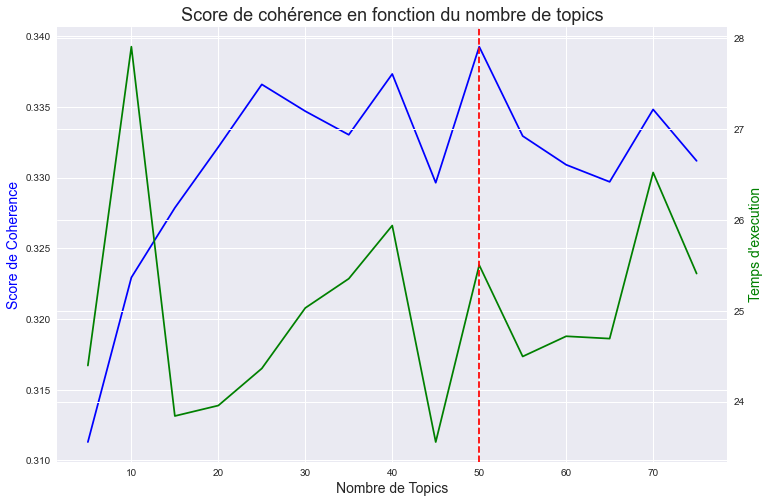

In [45]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(params, coherence_score, color="b")
ax2.plot(params, time_fit, color="g")
plt.axvline(50, color="r", linestyle='--', label="Le meileur paramètre est : 20")
plt.title("Score de cohérence en fonction du nombre de topics", fontsize=18)
ax1.set_xlabel("Nombre de Topics", fontsize=14)
ax1.set_ylabel("Score de Coherence", fontsize=14, color="b")
ax2.set_ylabel("Temps d'execution", fontsize=14, color="g")

In [14]:
best_lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=50)

In [15]:
ldaTags_gensim = np.vectorize(lambda x: dico.get(x))(best_lda.get_topics().argmax(axis=1))
topics_gensim = np.array(best_lda.get_document_topics(corpus, minimum_probability=0))[:,:,1]
topic_matrice_gensim = np.matmul(topics_gensim.T, y_train)
topic_matrice_gensim = topic_matrice_gensim/topic_matrice_gensim.sum(axis=1).reshape(-1,1)
print(topic_matrice_gensim.shape)
y_pred_lda_gensim = np.matmul(np.array(best_lda.get_document_topics(corpus_test, minimum_probability=0))[:,:,1], topic_matrice_gensim)

(50, 200)


In [58]:
models.add_prediction('lda gensim', y_pred_lda_gensim)
models.compute_perf('lda gensim')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
gensimvis.prepare(best_lda, corpus, dico)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
39    -0.005163  0.002174       1        1  3.491884
3     -0.002497 -0.002589       2        1  3.472032
34     0.006158 -0.002596       3        1  2.982739
36    -0.005174 -0.002078       4        1  2.810985
2     -0.006591  0.002638       5        1  2.717445
0     -0.001271 -0.009833       6        1  2.699103
4     -0.009008  0.005890       7        1  2.554659
37     0.014132  0.005251       8        1  2.466536
46     0.003034  0.000266       9        1  2.420208
49    -0.017012  0.001247      10        1  2.342653
7     -0.004756  0.004700      11        1  2.328852
35     0.021307 -0.012232      12        1  2.236324
20     0.015473 -0.003599      13        1  2.225884
12    -0.010722  0.014096      14        1  2.219215
43     0.002163  0.001638      15        1  2.150560
23     0.007963  0.002071      16        1  2.128994
42     0.005824  0.001330      17        1  2.081306
31    -0.008460 -0.002317      18        1  2.074575
15     0.009449  0.010841      19        1  2.041362
18     0.002929  0.004898      20        1  2.038531
22     0.001706 -0.013497      21        1  2.035161
45     0.017987 -0.004750      22        1  2.022102
17    -0.000348  0.000683      23        1  2.013071
27    -0.004881 -0.000010      24        1  1.991161
19     0.008751 -0.011733      25        1  1.983883
25    -0.002851 -0.001944      26        1  1.960266
13     0.023650 -0.002811      27        1  1.917434
41    -0.006108  0.001354      28        1  1.877705
33     0.002408 -0.006944      29        1  1.852935
16     0.004299  0.010309      30        1  1.849525
24     0.007955 -0.011625      31        1  1.833286
5      0.003753  0.005605      32        1  1.804427
26     0.007944  0.011832      33        1  1.795770
8     -0.030393  0.010770      34        1  1.762089
44     0.004403  0.008095      35        1  1.758867
9     -0.005616  0.001524      36        1  1.754557
48     0.001880  0.016392      37        1  1.746808
28    -0.016647  0.021452      38        1  1.718986
1      0.002807  0.008999      39        1  1.669992
11     0.001515  0.002521      40        1  1.655896
29    -0.002302 -0.005711      41        1  1.620260
14     0.028772 -0.015905      42        1  1.585487
10    -0.022403  0.013077      43        1  1.474190
30     0.001026 -0.006631      44        1  1.412550
40    -0.012042  0.014257      45        1  1.370561
6      0.013733  0.021400      46        1  1.365158
32     0.007277  0.007429      47        1  1.361510
38    -0.043128  0.034294      48        1  1.240252
47     0.058044 -0.045401      49        1  1.102519
21    -0.068965 -0.084825      50        1  0.979745, topic_info=            Term         Freq        Total Category  logprob  loglift
42          code  5272.000000  5272.000000  Default  30.0000  30.0000
49          work  3358.000000  3358.000000  Default  29.0000  29.0000
50          file  2754.000000  2754.000000  Default  28.0000  28.0000
47        return  1267.000000  1267.000000  Default  27.0000  27.0000
131        error  3135.000000  3135.000000  Default  26.0000  26.0000
17      function  1920.000000  1920.000000  Default  25.0000  25.0000
65          data  2178.000000  2178.000000  Default  24.0000  24.0000
38          time  1686.000000  1686.000000  Default  23.0000  23.0000
453  application  1356.000000  1356.000000  Default  22.0000  22.0000
23        method  1620.000000  1620.000000  Default  21.0000  21.0000
26       problem  2633.000000  2633.000000  Default  20.0000  20.0000
167        query   807.000000   807.000000  Default  19.0000  19.0000
3            don  1748.000000  1748.000000  Default  18.0000  18.0000
100       simple   925.000000   925.000000  Default  17.0000  17.0000
28           set  1609.000000  1609.000000  Default  16.0000  16.0000
119      working  1819.000000  1819.000000  Default  15.0000  15.0000
236       a

### LDA Sklearn

In [29]:
lda = LatentDirichletAllocation(
    n_components=100, 
    n_jobs=-1)
lda.fit(x_train_counts)
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn_100 = np.matmul(lda.transform(x_test_counts), topic_matrice)

lda = LatentDirichletAllocation(
    n_components=200, 
    n_jobs=-1)
lda.fit(x_train_counts)
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn_200 = np.matmul(lda.transform(x_test_counts), topic_matrice)

lda = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1)
lda.fit(x_train_counts)
# ldaTags = np.vectorize(lambda x: vocabulary[x])(lda.components_.argmax(axis=1))
topic_matrice = np.matmul(lda.transform(x_train_counts).T, y_train)
topic_matrice = topic_matrice/topic_matrice.sum(axis=1).reshape(-1,1)
print(topic_matrice.shape)
y_pred_lda_sklearn = np.matmul(lda.transform(x_test_counts), topic_matrice)

(100, 200)
(200, 200)
(50, 200)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
models.add_prediction('LDA Sklearn', y_pred_lda_sklearn)
models.add_prediction('LDA Sklearn 100 topic', y_pred_lda_sklearn_100)
models.add_prediction('LDA Sklearn 200 topic', y_pred_lda_sklearn_200)

models.compute_perf('LDA Sklearn')
models.compute_perf('LDA Sklearn 100 topic')
models.compute_perf('LDA Sklearn 200 topic')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
LDAsklearn.prepare(lda, x_train_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
28    -0.021339 -0.053173       1        1  3.400938
19    -0.123664 -0.164283       2        1  3.327656
17     0.139343  0.015347       3        1  3.309576
35    -0.167685 -0.162832       4        1  3.128436
31     0.086706 -0.044474       5        1  3.048991
21    -0.086809 -0.076579       6        1  3.029177
41    -0.109721 -0.075645       7        1  2.905649
7     -0.048971 -0.135305       8        1  2.879261
12     0.094630 -0.030627       9        1  2.874536
26    -0.021288 -0.030149      10        1  2.537630
14    -0.037216 -0.099880      11        1  2.496225
6      0.048259 -0.131592      12        1  2.367088
47    -0.108160  0.099809      13        1  2.302103
15    -0.105938 -0.112118      14        1  2.284747
43    -0.107221 -0.044959      15        1  2.248315
22    -0.089198  0.183927      16        1  2.125178
49    -0.104492  0.164149      17        1  2.119151
36     0.125746 -0.084612      18        1  2.098457
46     0.075731 -0.046165      19        1  2.032509
2     -0.084617  0.107321      20        1  1.971124
44     0.183513  0.050510      21        1  1.958615
9     -0.088099  0.041105      22        1  1.885449
33     0.111339  0.018368      23        1  1.866448
10    -0.093686  0.169263      24        1  1.860750
34    -0.133174  0.174133      25        1  1.842616
40     0.079588 -0.046721      26        1  1.795604
20    -0.055158  0.055720      27        1  1.771853
5      0.157247 -0.061714      28        1  1.757344
37     0.142293  0.036209      29        1  1.753210
11    -0.061122  0.159078      30        1  1.702884
39     0.081942 -0.052955      31        1  1.673274
38     0.016803  0.055234      32        1  1.641504
0      0.192394  0.113010      33        1  1.609637
48    -0.112715  0.163815      34        1  1.605354
29    -0.112719 -0.177887      35        1  1.601895
4     -0.021123 -0.094827      36        1  1.596013
45    -0.042183 -0.110503      37        1  1.583905
16    -0.008917 -0.011103      38        1  1.572037
18    -0.051165 -0.002677      39        1  1.554263
13     0.120260  0.010231      40        1  1.509777
23    -0.032607  0.022427      41        1  1.436553
25     0.016372 -0.073548      42        1  1.433933
32    -0.004345  0.039028      43        1  1.432651
24    -0.016683  0.084836      44        1  1.403953
42     0.143827  0.021927      45        1  1.396686
1      0.223609  0.054020      46        1  1.370497
8      0.004072  0.086669      47        1  1.339223
3     -0.004740 -0.000631      48        1  1.316808
30     0.051813 -0.006406      49        1  1.265958
27    -0.040732  0.005229      50        1  0.974556, topic_info=               Term         Freq        Total Category  logprob  loglift
697            file  6409.000000  6409.000000  Default  30.0000  30.0000
622           error  5509.000000  5509.000000  Default  29.0000  29.0000
441            data  4017.000000  4017.000000  Default  28.0000  28.0000
746        function  3462.000000  3462.000000  Default  27.0000  27.0000
1198         object  2412.000000  2412.000000  Default  26.0000  26.0000
1892           user  3254.000000  3254.000000  Default  25.0000  25.0000
121           array  2153.000000  2153.000000  Default  24.0000  24.0000
1029           list  2152.000000  2152.000000  Default  23.0000  23.0000
293           class  2850.000000  2850.000000  Default  22.0000  22.0000
871           image  2245.000000  2245.000000  Default  21.0000  21.0000
1767          table  2504.000000  2504.000000  Default  20.0000  20.0000
322          column  1778.000000  1778.000000  Default  19.0000  19.0000
1123         method  2708.000000  2708.000000  Default  18.0000  18.0000
1917           view  1760.000000  1760.000000  Default  17.0000  17.0000
1723         string  2193.000000  2193.000000  Default  16.0000  16.0000
233          button  1875.000000 

### NMF Sklearn

In [32]:
nmf = NMF(n_components=100)
nmf.fit(x_train_counts)
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf_100 = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)

nmf = NMF(n_components=200)
nmf.fit(x_train_counts)
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf_200 = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)

nmf = NMF(n_components=50)
nmf.fit(x_train_counts)
# nmfTags = np.vectorize(lambda x: vocabulary[x])(nmf.components_.argmax(axis=1))
topic_matrice_nmf = np.matmul(nmf.transform(x_train_counts).T, y_train)
topic_matrice_nmf = topic_matrice_nmf/topic_matrice_nmf.sum(axis=1).reshape(-1,1)
print(topic_matrice_nmf.shape)
y_pred_nmf = np.matmul(nmf.transform(x_test_counts), topic_matrice_nmf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(100, 200)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(200, 200)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


(50, 200)


In [60]:
models.add_prediction('NMF Sklearn', y_pred_nmf)
models.add_prediction('NMF Sklearn 100', y_pred_nmf_100)
models.add_prediction('NMF Sklearn 200', y_pred_nmf_200)

models.compute_perf('NMF Sklearn')
models.compute_perf('NMF Sklearn 100')
models.compute_perf('NMF Sklearn 200')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


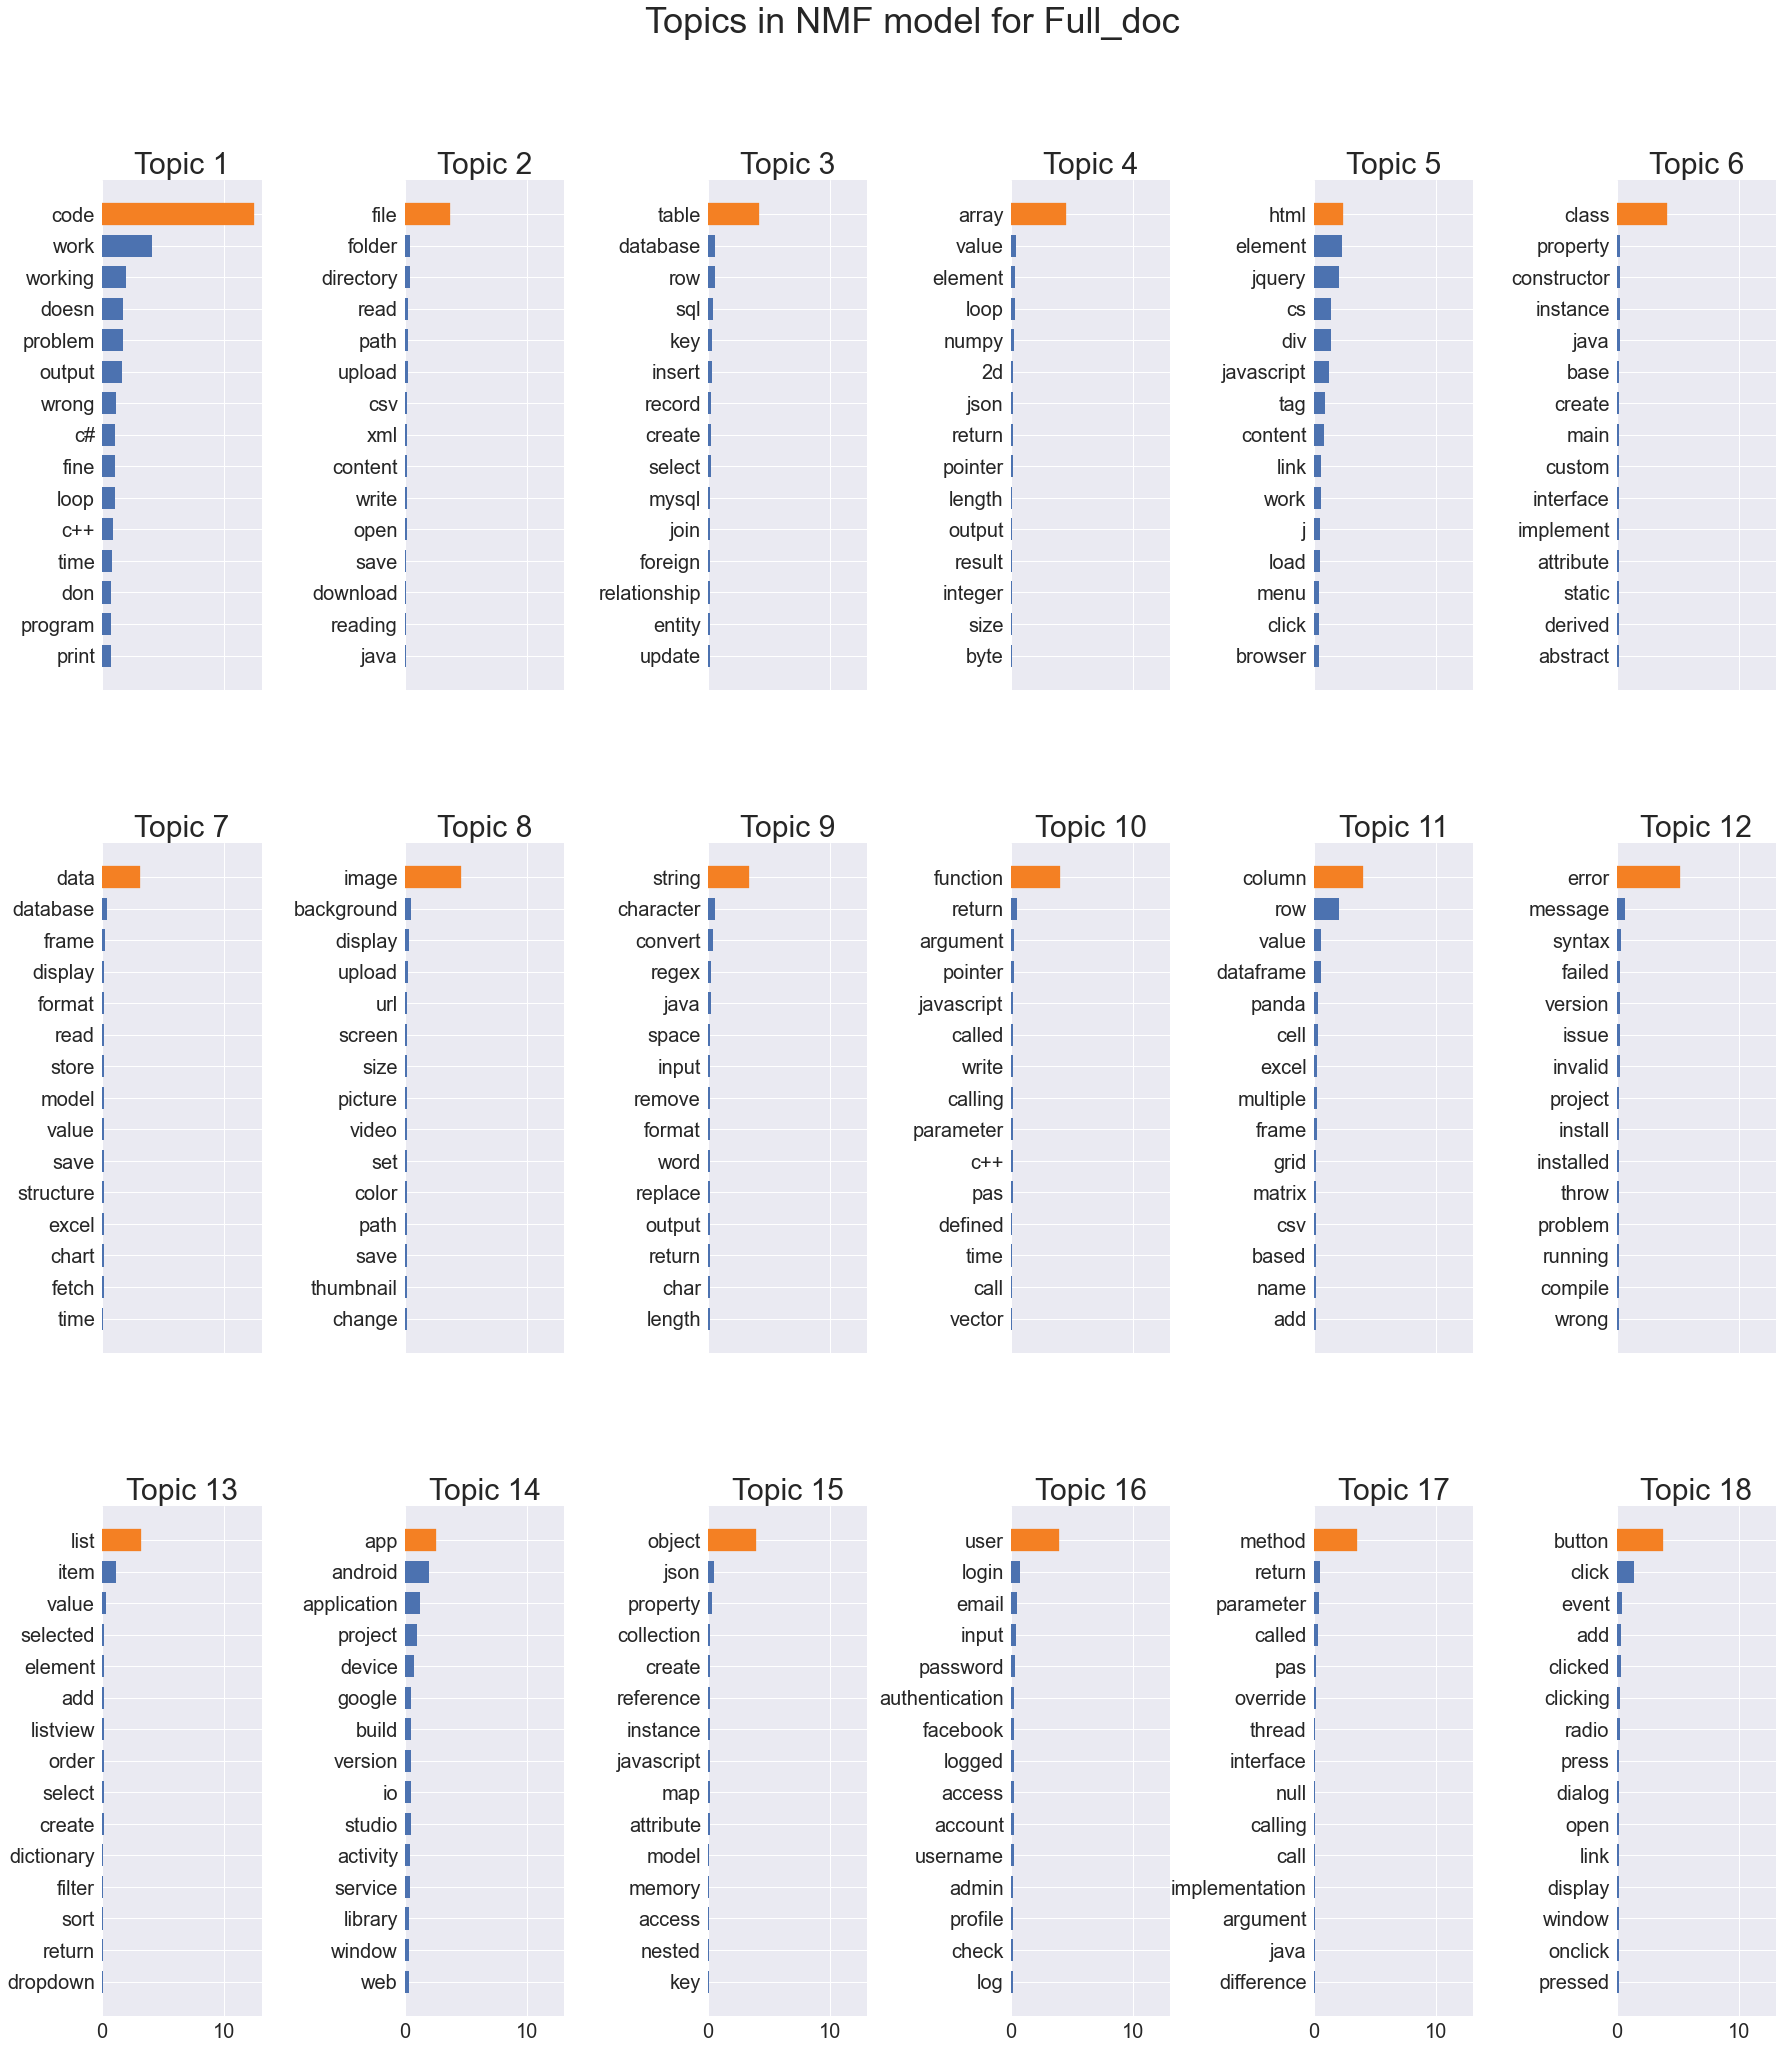

In [38]:
# Initializing the NMF
full_nmf = NMF(n_components=30, init="nndsvda", random_state=129)

# Fit NMF on Body vectorized
full_nmf.fit(x_train_tfidf)

# Plot the 12 first topics
ff_feature_names = count_vect.get_feature_names()
plot_top_words(full_nmf, ff_feature_names, 15, 3,
               'Topics in NMF model for Full_doc')

## Selection et Visualisation

In [65]:
models.models

data_use model                     confusion_matrice  \
name                                                                         
lda gensim                 NaN   NaN   [[3931.22, 30.715], [32.615, 5.45]]   
LDA Sklearn                NaN   NaN   [[3932.755, 26.285], [31.08, 9.88]]   
LDA Sklearn 100 topic      NaN   NaN   [[3936.785, 26.845], [27.05, 9.32]]   
LDA Sklearn 200 topic      NaN   NaN  [[3939.18, 25.815], [24.655, 10.35]]   
NMF Sklearn                NaN   NaN   [[3924.73, 28.74], [39.105, 7.425]]   
NMF Sklearn 100            NaN   NaN   [[3943.41, 30.025], [20.425, 6.14]]   
NMF Sklearn 200            NaN   NaN   [[3933.625, 27.705], [30.21, 8.46]]   

                          Error Jaccard Macro Precision Macro Recall Macro  \
name                                                                         
lda gensim             0.015832      0.004666        0.006929     0.015549   
LDA Sklearn            0.014341      0.017082         0.04174     0.038445   
LDA Sklearn 100 topic  0.013474       0.01551        0.044921     0.032556   
LDA Sklearn 200 topic  0.012618      0.022492        0.095502     0.040508   
NMF Sklearn            0.016961      0.012734        0.042126     0.031285   
NMF Sklearn 100        0.012613      0.014825        0.060345     0.026106   
NMF Sklearn 200        0.014479      0.029525         0.09582     0.049364   

                      F_mesure Macro auc Macro Jaccard Micro Precision Micro  \
name                                                                           
lda gensim                  0.008405  0.690819      0.079238        0.143176   
LDA Sklearn                 0.028114  0.894639      0.146925        0.241211   
LDA Sklearn 100 topic       0.024882  0.912521      0.147433        0.256255   
LDA Sklearn 200 topic       0.036745   0.92978      0.170174        0.295672   
NMF Sklearn                 0.022457  0.722918      0.098645        0.159574   
NMF Sklearn 100             0.025376  0.766446        0.1085        0.231131   
NMF Sklearn 200              0.04686  0.799364      0.127458        0.218774   

                      Recall Micro F_mesure Micro auc Micro  \
name                                                          
lda gensim                0.150698       0.146841  0.836362   
LDA Sklearn               0.273192       0.256207  0.906319   
LDA Sklearn 100 topic     0.257708       0.256979  0.910282   
LDA Sklearn 200 topic     0.286188       0.290853  0.921343   
NMF Sklearn               0.205309       0.179576  0.847304   
NMF Sklearn 100           0.169777        0.19576  0.864676   
NMF Sklearn 200           0.233928       0.226097  0.880097   

                      proportion_de_prédiction fit_time pred_time  \
name                                                                
lda gensim                            1.052537        0         0   
LDA Sklearn                           1.132587        0         0   
LDA Sklearn 100 topic                 1.005668        0         0   
LDA Sklearn 200 topic                 0.967925        0         0   
NMF Sklearn                           1.286603        0         0   
NMF Sklearn 100                        0.73455        0         0   
NMF Sklearn 200                       1.069266        0         0   

                                                                  y_pred  \
name                                                                       
lda gensim             [[0.00015212547001515846, 0.008946550358881337...   
LDA Sklearn            [[0.0009266527989819372, 0.01015376689797964, ...   
LDA Sklearn 100 topic  [[0.0011539480703696926, 0.011204657082931344,...   
LDA Sklearn 200 topic  [[0.0018401732800343738, 0.009182445987471841,...   
NMF Sklearn            [[0.0010677174427137026, 0.006944044274676765,...   
NMF Sklearn 100        [[0.0018287703912733193, 0.009567481634707735,...   
NMF Sklearn 200        [[0.0005712144583558831, 0.0054526558700121975...   

                    

C:\Users\MaxiLi\AppData\Local\Temp/ipykernel_50056/2509556036.py:240: RuntimeWarning: invalid value encountered in true_divide
  colors = cm.plasma_r(value / float(max(value)))


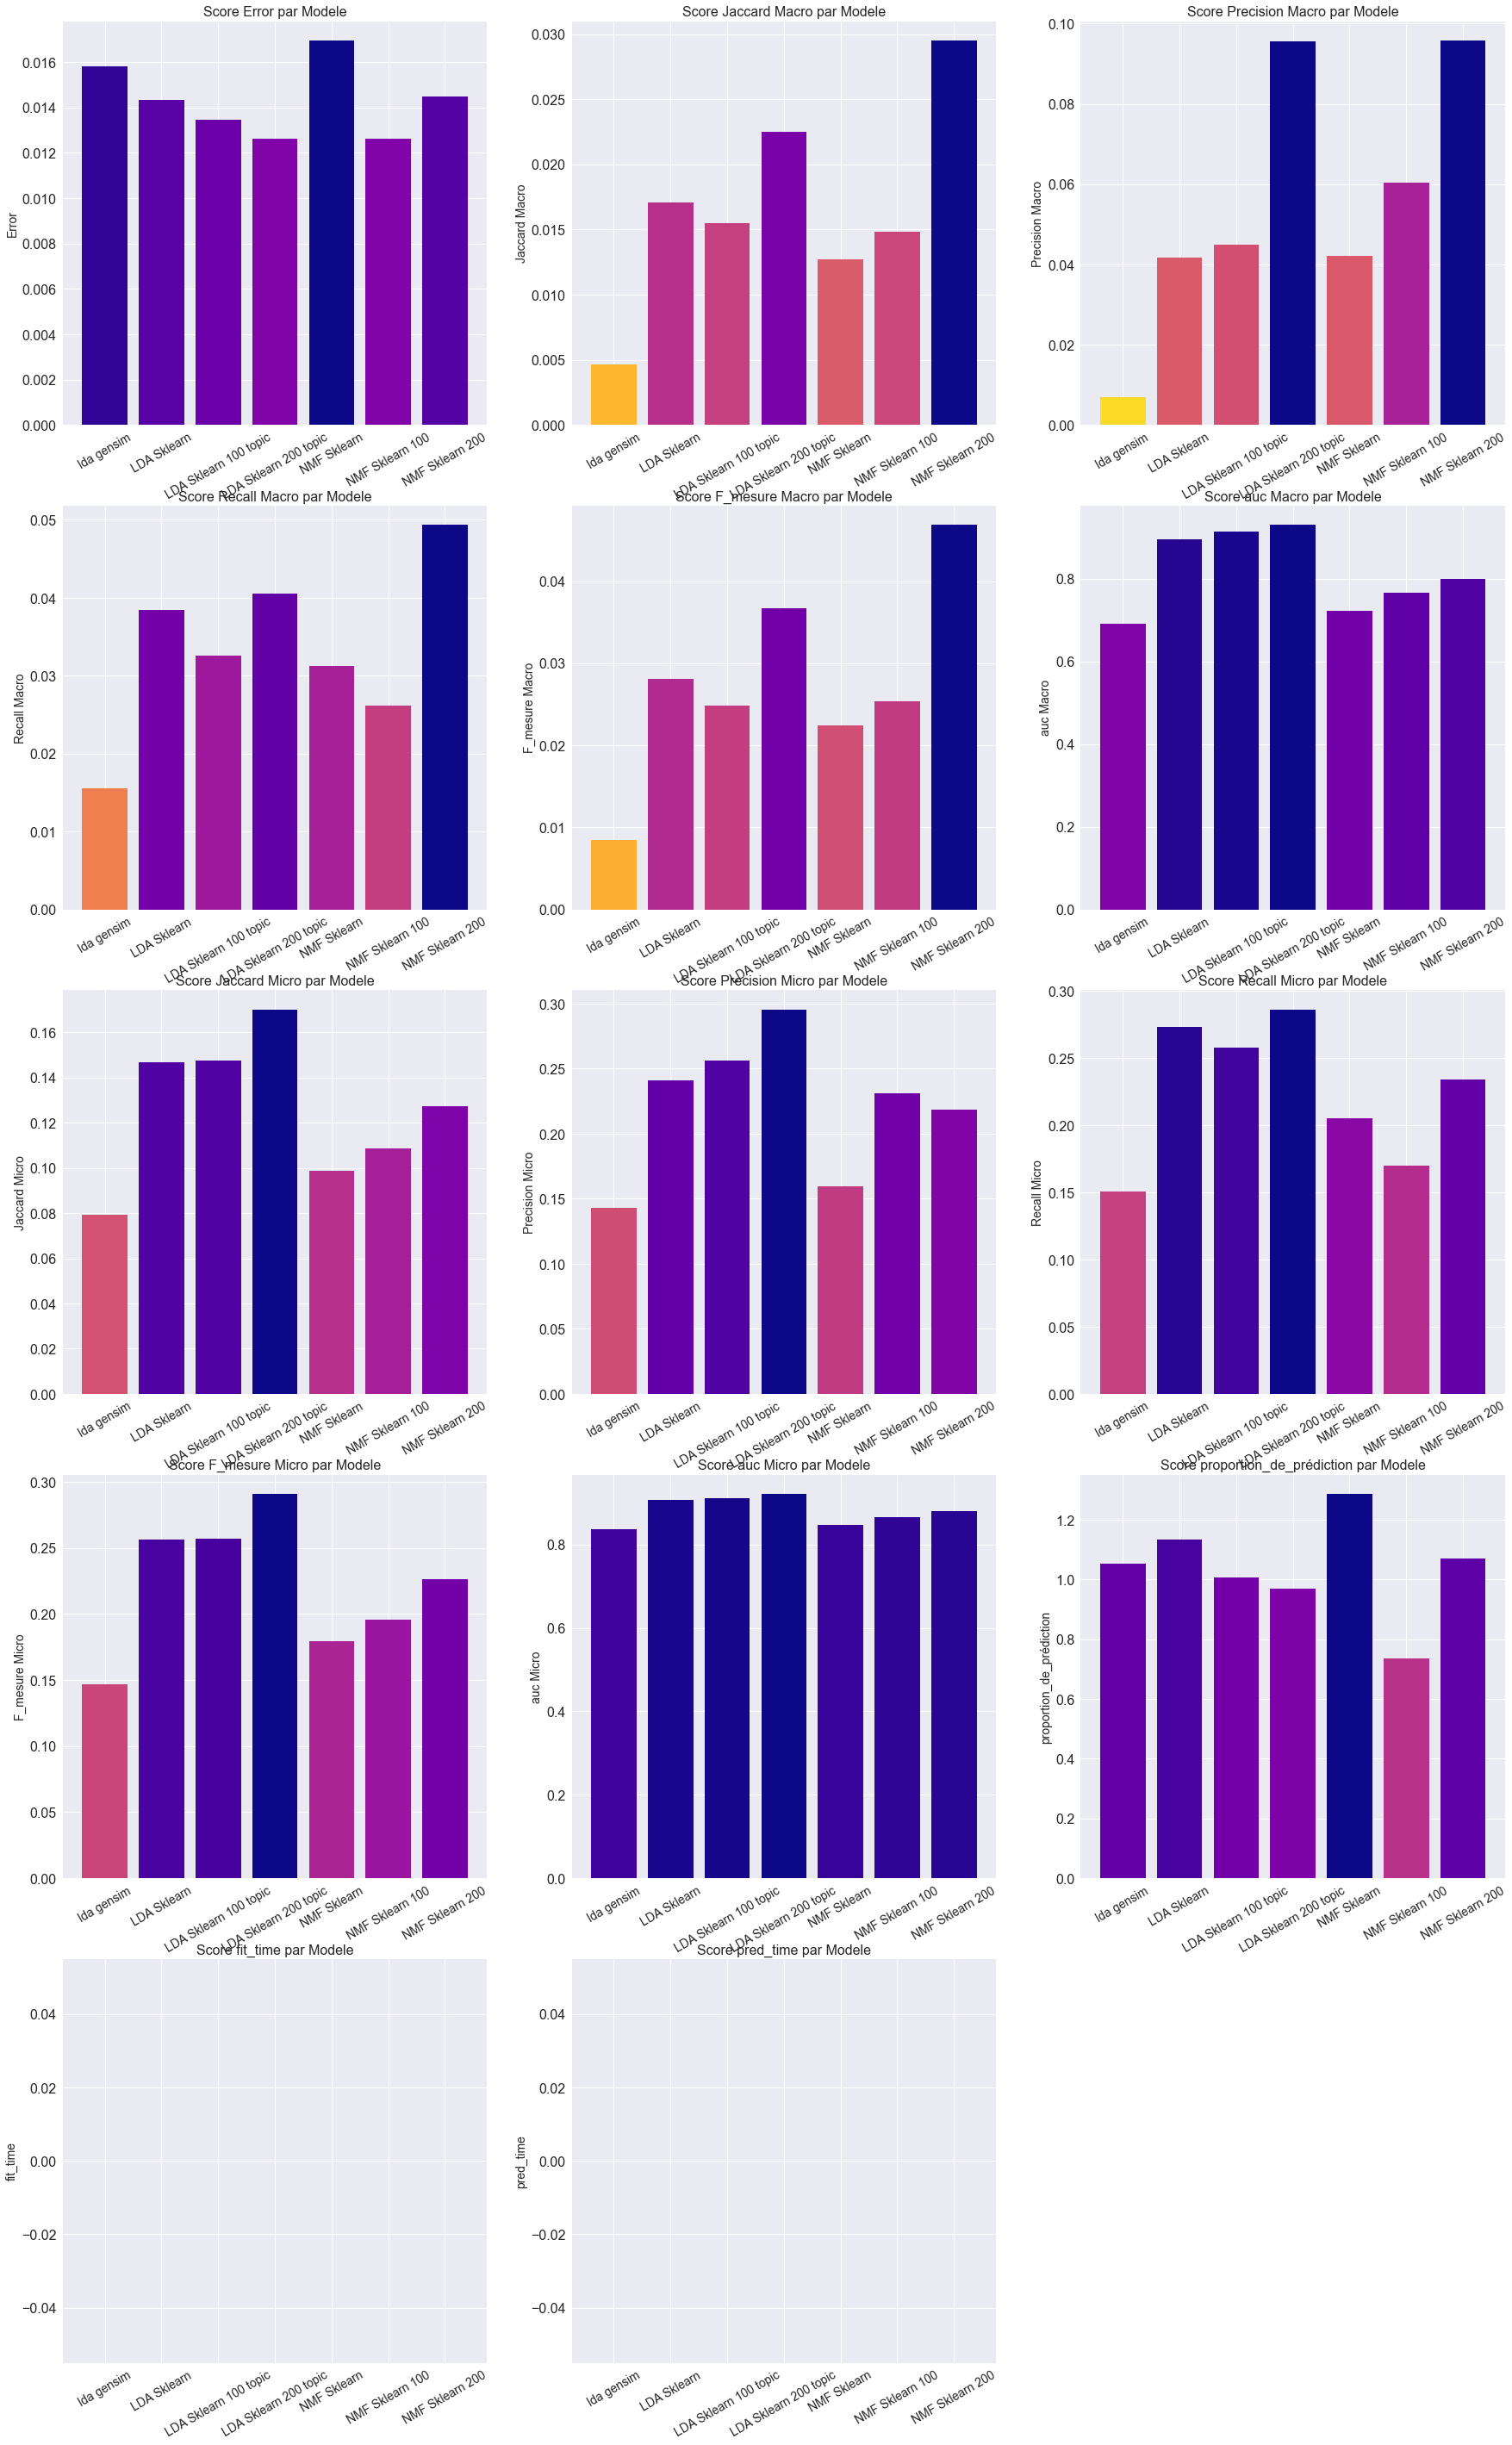

In [66]:
models.plot_perf()

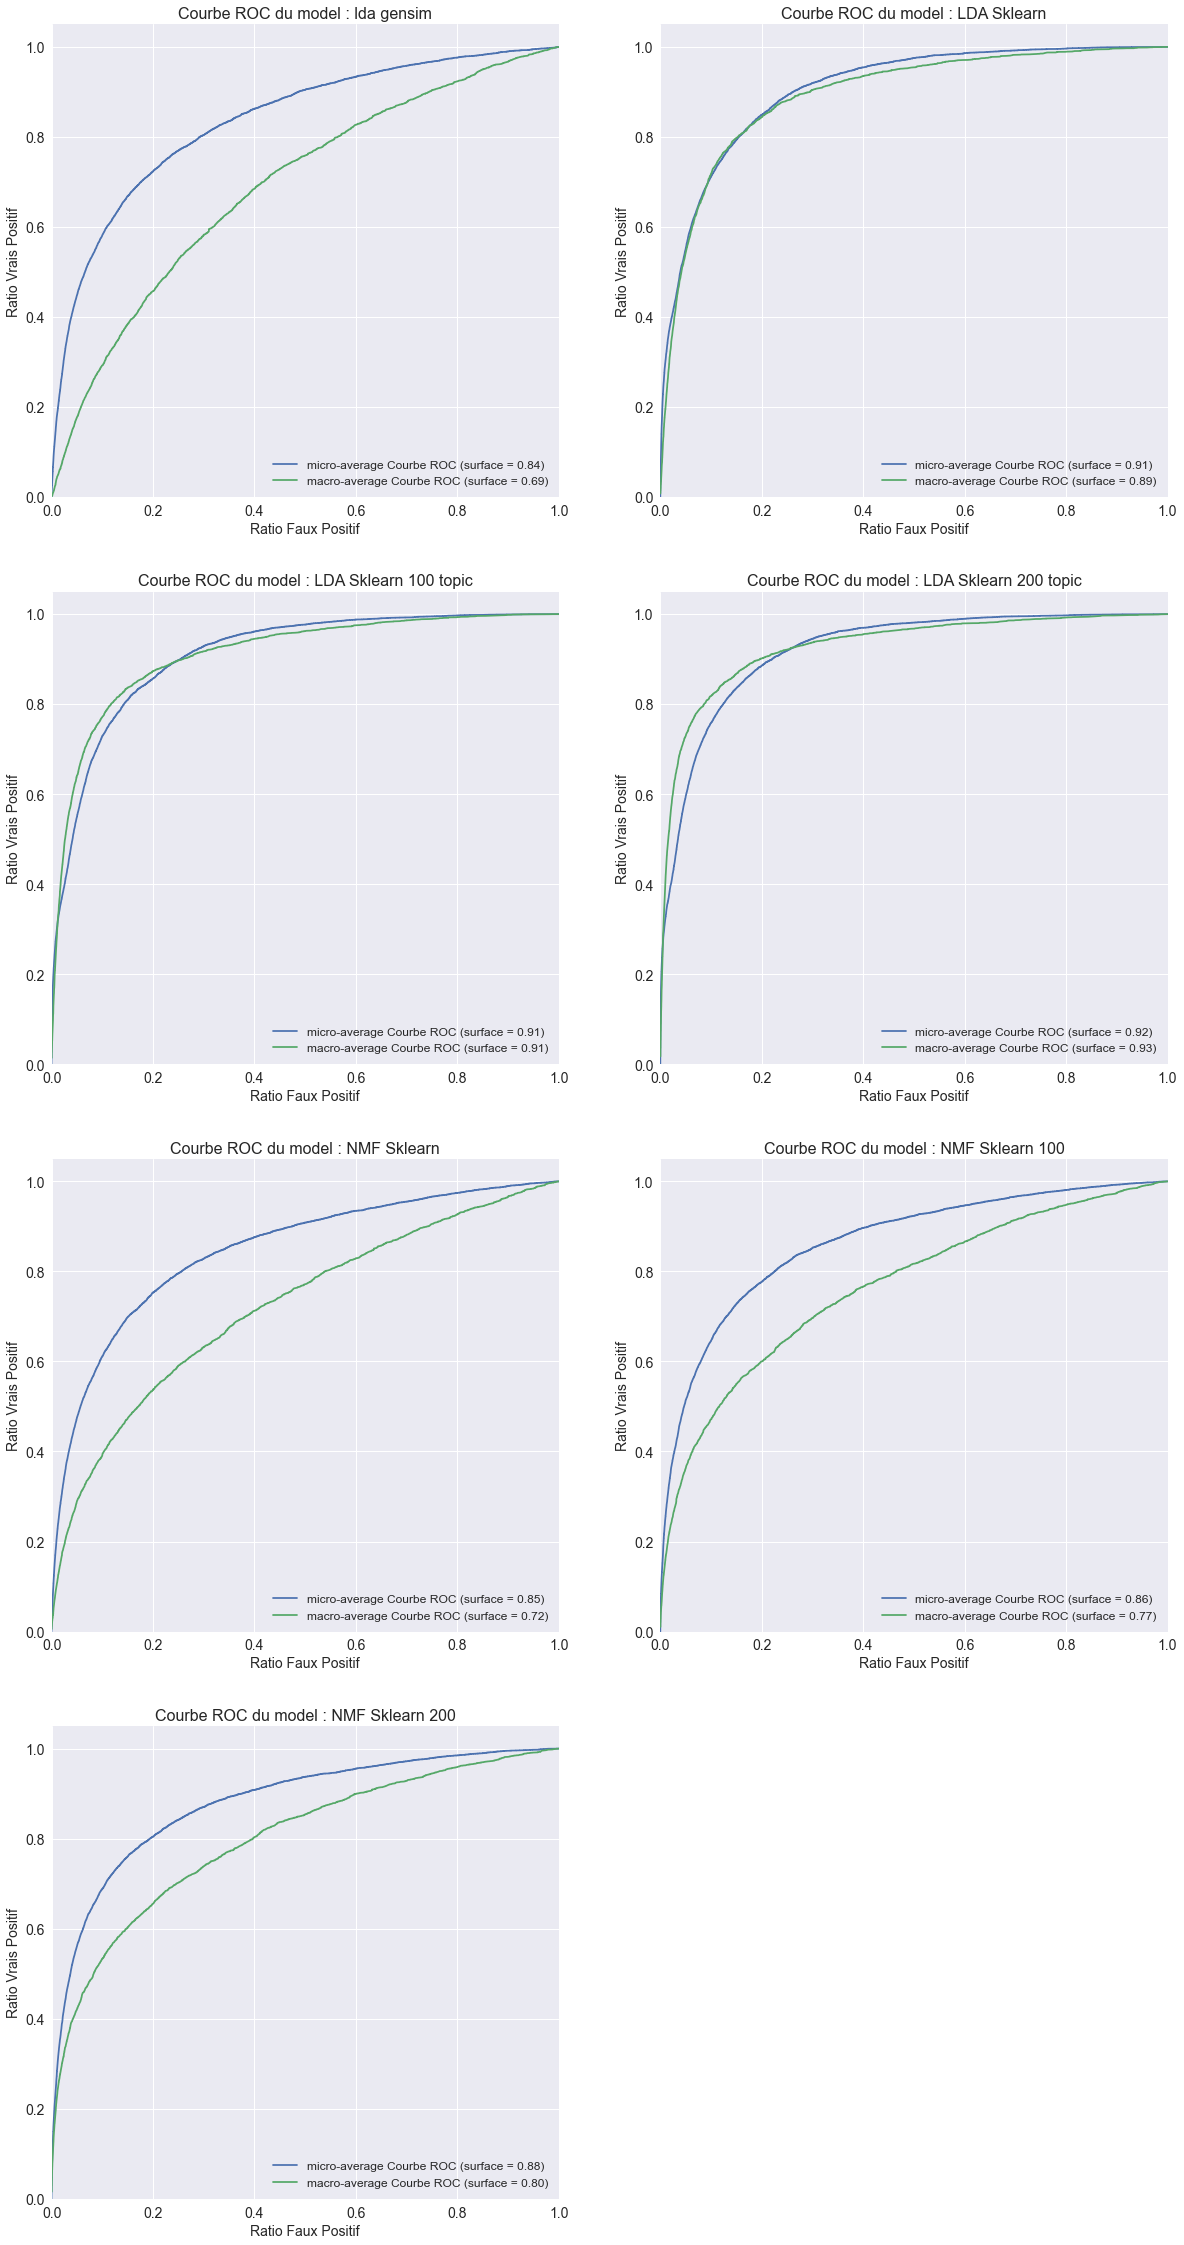

In [67]:
models.plot_roc()

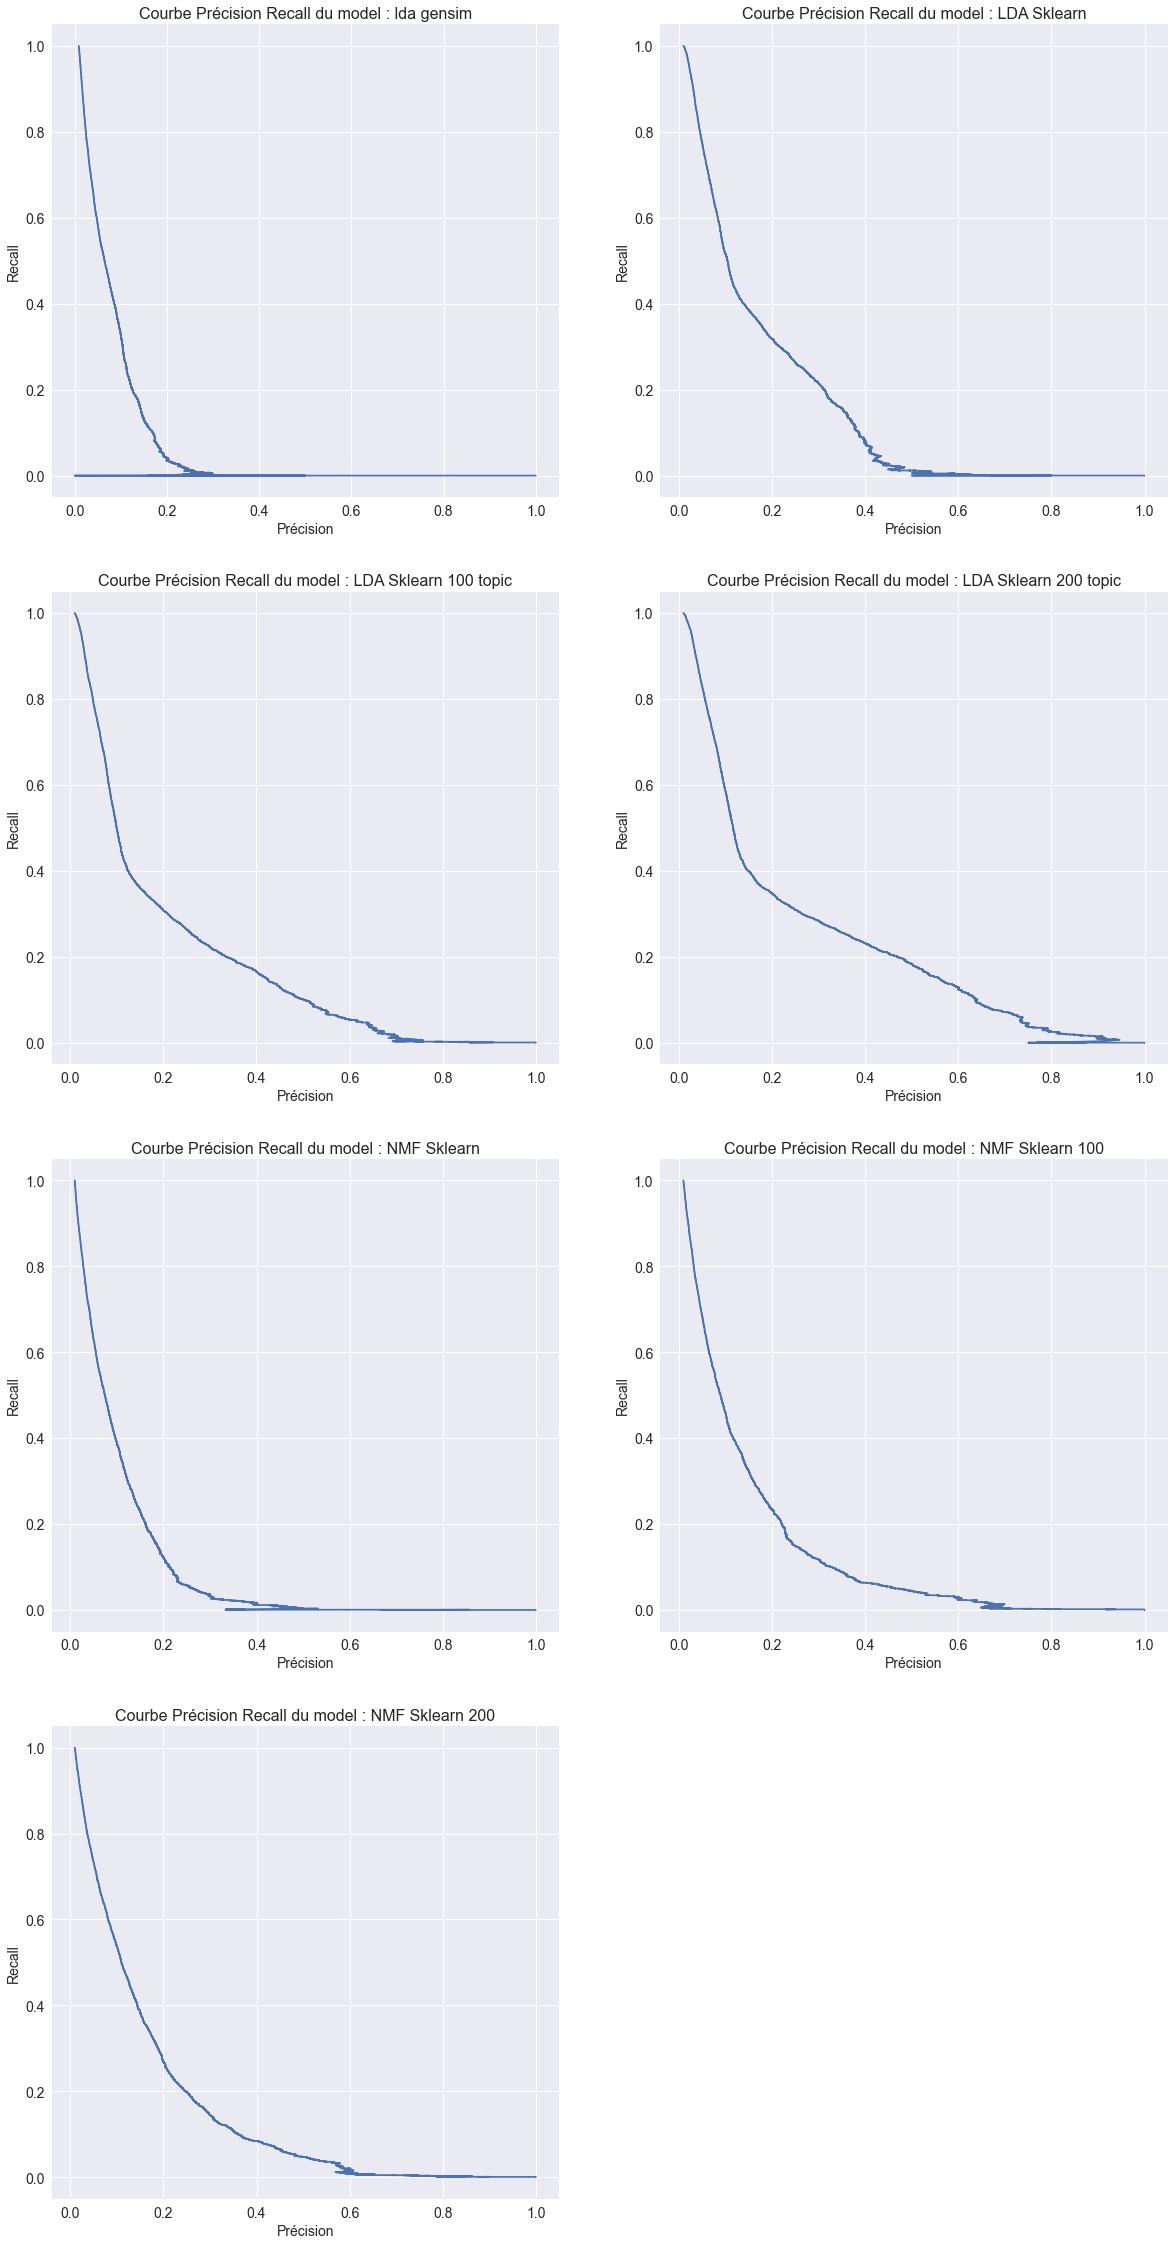

In [68]:
models.plot_precision_recall()